<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# Only consider houses that are residential.
df_residental_house = house[house['MSZoning'].isin(['FV', 'RH', 'RL', 'RP', 'RM'])].copy()
df_residental_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_residental_house.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [5]:
df_residental_house.shape

(1450, 81)

In [6]:
# Check for existance of null values.
df_isnull = df_residental_house.apply(lambda v: v.isnull().sum())
df_isnull[df_isnull > 0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

In [7]:
# Assume that properties with null LotFrontage have zero feet of street connected to property
df_residental_house.loc[df_residental_house['LotFrontage'].isnull(), 'LotFrontage'] = 0

In [8]:
# Assume that properties without alleys (those whose values are null) have no alley access
df_residental_house.loc[df_residental_house['Alley'].isnull(), 'Alley'] = 'NA'

In [9]:
# Assert that missing values for BsmtQual, BsmtCond and BsmtFinType1 is NA.
print(
    len(df_residental_house[(df_residental_house['TotalBsmtSF'] > 0) & df_residental_house['BsmtQual'].isnull()]),
    len(df_residental_house[(df_residental_house['TotalBsmtSF'] > 0) & df_residental_house['BsmtCond'].isnull()]),
    len(df_residental_house[(df_residental_house['TotalBsmtSF'] > 0) & df_residental_house['BsmtFinType1'].isnull()])
)

(0, 0, 0)


In [10]:
# Fill in missing values for BsmtQual, BsmtCond and BsmtFinType1
df_residental_house.loc[(df_residental_house['TotalBsmtSF'] == 0) & df_residental_house['BsmtQual'].isnull(), 'BsmtQual'] = 'NA'
df_residental_house.loc[(df_residental_house['TotalBsmtSF'] == 0) & df_residental_house['BsmtCond'].isnull(), 'BsmtCond'] = 'NA'
df_residental_house.loc[(df_residental_house['TotalBsmtSF'] == 0) & df_residental_house['BsmtFinType1'].isnull(), 'BsmtFinType1'] = 'NA'

In [11]:
# Assert that the missing value of FireplaceQu is NA
len(df_residental_house[(df_residental_house['Fireplaces'] > 0) & df_residental_house['FireplaceQu'].isnull()])

0

In [12]:
# Fill in missing values for FireplaceQu
df_residental_house.loc[(df_residental_house['Fireplaces'] == 0) & df_residental_house['FireplaceQu'].isnull(), 'FireplaceQu'] = 'NA'

In [13]:
# Assert that the null values for GarageType, GarageYrBlt, GarageFinish, GarageQual and GarageCond is NA.
print(
    len(df_residental_house[(df_residental_house['GarageArea'] > 0) & df_residental_house['GarageType'].isnull()]),
    len(df_residental_house[(df_residental_house['GarageArea'] > 0) & df_residental_house['GarageYrBlt'].isnull()]),
    len(df_residental_house[(df_residental_house['GarageArea'] > 0) & df_residental_house['GarageFinish'].isnull()]),
    len(df_residental_house[(df_residental_house['GarageArea'] > 0) & df_residental_house['GarageQual'].isnull()]),
    len(df_residental_house[(df_residental_house['GarageArea'] > 0) & df_residental_house['GarageCond'].isnull()])
)

(0, 0, 0, 0, 0)


In [14]:
# Fill in missing values for GarageType, GarageFinish, GarageQual and GarageCond
df_residental_house.loc[(df_residental_house['GarageArea'] == 0) & df_residental_house['GarageType'].isnull(), 'GarageType'] = 'NA'
df_residental_house.loc[(df_residental_house['GarageArea'] == 0) & df_residental_house['GarageFinish'].isnull(), 'GarageFinish'] = 'NA'
df_residental_house.loc[(df_residental_house['GarageArea'] == 0) & df_residental_house['GarageQual'].isnull(), 'GarageQual'] = 'NA'
df_residental_house.loc[(df_residental_house['GarageArea'] == 0) & df_residental_house['GarageCond'].isnull(), 'GarageCond'] = 'NA'

In [15]:
# Assert that the null value for PoolQC is NA.
len(df_residental_house[(df_residental_house['PoolArea'] > 0) & df_residental_house['PoolQC'].isnull()])

0

In [16]:
# Fill in the PoolQC with 'NA' for PoolArea = 0
df_residental_house.loc[(df_residental_house['PoolArea'] == 0) & df_residental_house['PoolQC'].isnull(), 'PoolQC'] = 'NA'

In [17]:
# Assert that the null value for MiscFeature is NA (No misc feature).
len(df_residental_house[(df_residental_house['MiscVal'] > 0) & df_residental_house['MiscFeature'].isnull()])

0

In [18]:
# For null MiscFeature, the MiscVal is zero. Hence we can assume that there is no misc feature.
df_residental_house.loc[(df_residental_house['MiscVal'] == 0) & df_residental_house['MiscFeature'].isnull(), 'MiscFeature'] = 'NA'

In [19]:
df_residental_house.loc[(df_residental_house['TotalBsmtSF'] > 0) & df_residental_house['BsmtExposure'].isnull(), ['BsmtExposure', 'BsmtUnfSF', 'TotalBsmtSF']]

,BsmtExposure,BsmtUnfSF,TotalBsmtSF
948,NaN,936,936


In [20]:
df_residental_house.loc[(df_residental_house['TotalBsmtSF'] > 0) & df_residental_house['BsmtFinType2'].isnull(), ['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,GLQ,1124,NaN,479,1603,3206


In [21]:
print(
    len(df_residental_house[df_residental_house['MasVnrArea'].isnull() & df_residental_house['MasVnrType'].isnull()]),
    len(df_residental_house[(df_residental_house['MasVnrArea'] > 0) & df_residental_house['MasVnrType'].isnull()]),
    len(df_residental_house[(df_residental_house['MasVnrArea'] == 0) & df_residental_house['MasVnrType'].isnull()])
)

(8, 0, 0)


In [22]:
# Assume that property with null value in Electrical are mixed
df_residental_house.loc[df_residental_house['Electrical'].isnull(), 'Electrical'] = 'Mix'

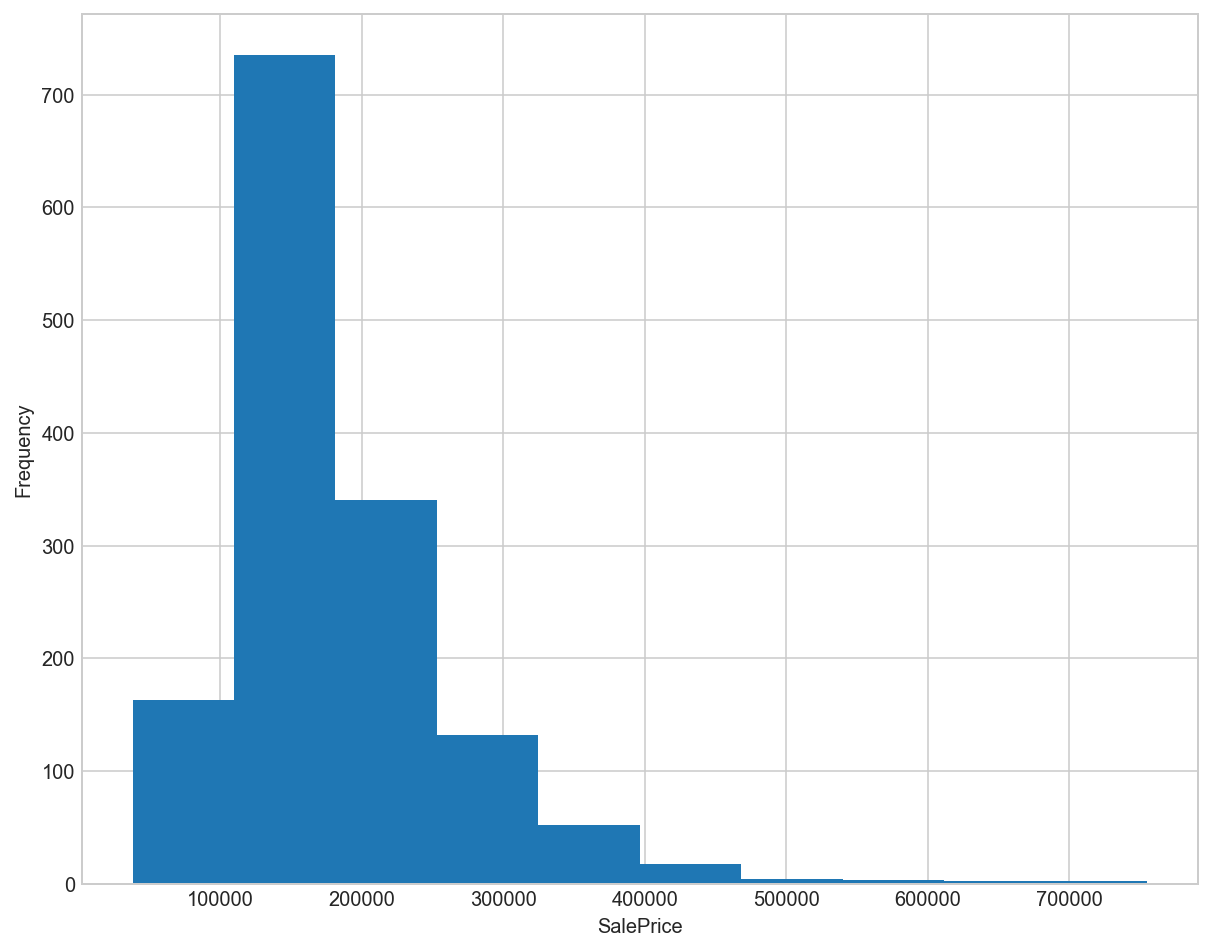

In [23]:
ax_hist_price = df_residental_house['SalePrice'].plot.hist(figsize=(10, 8))
ax_hist_price.set_xlabel('SalePrice')
plt.show()

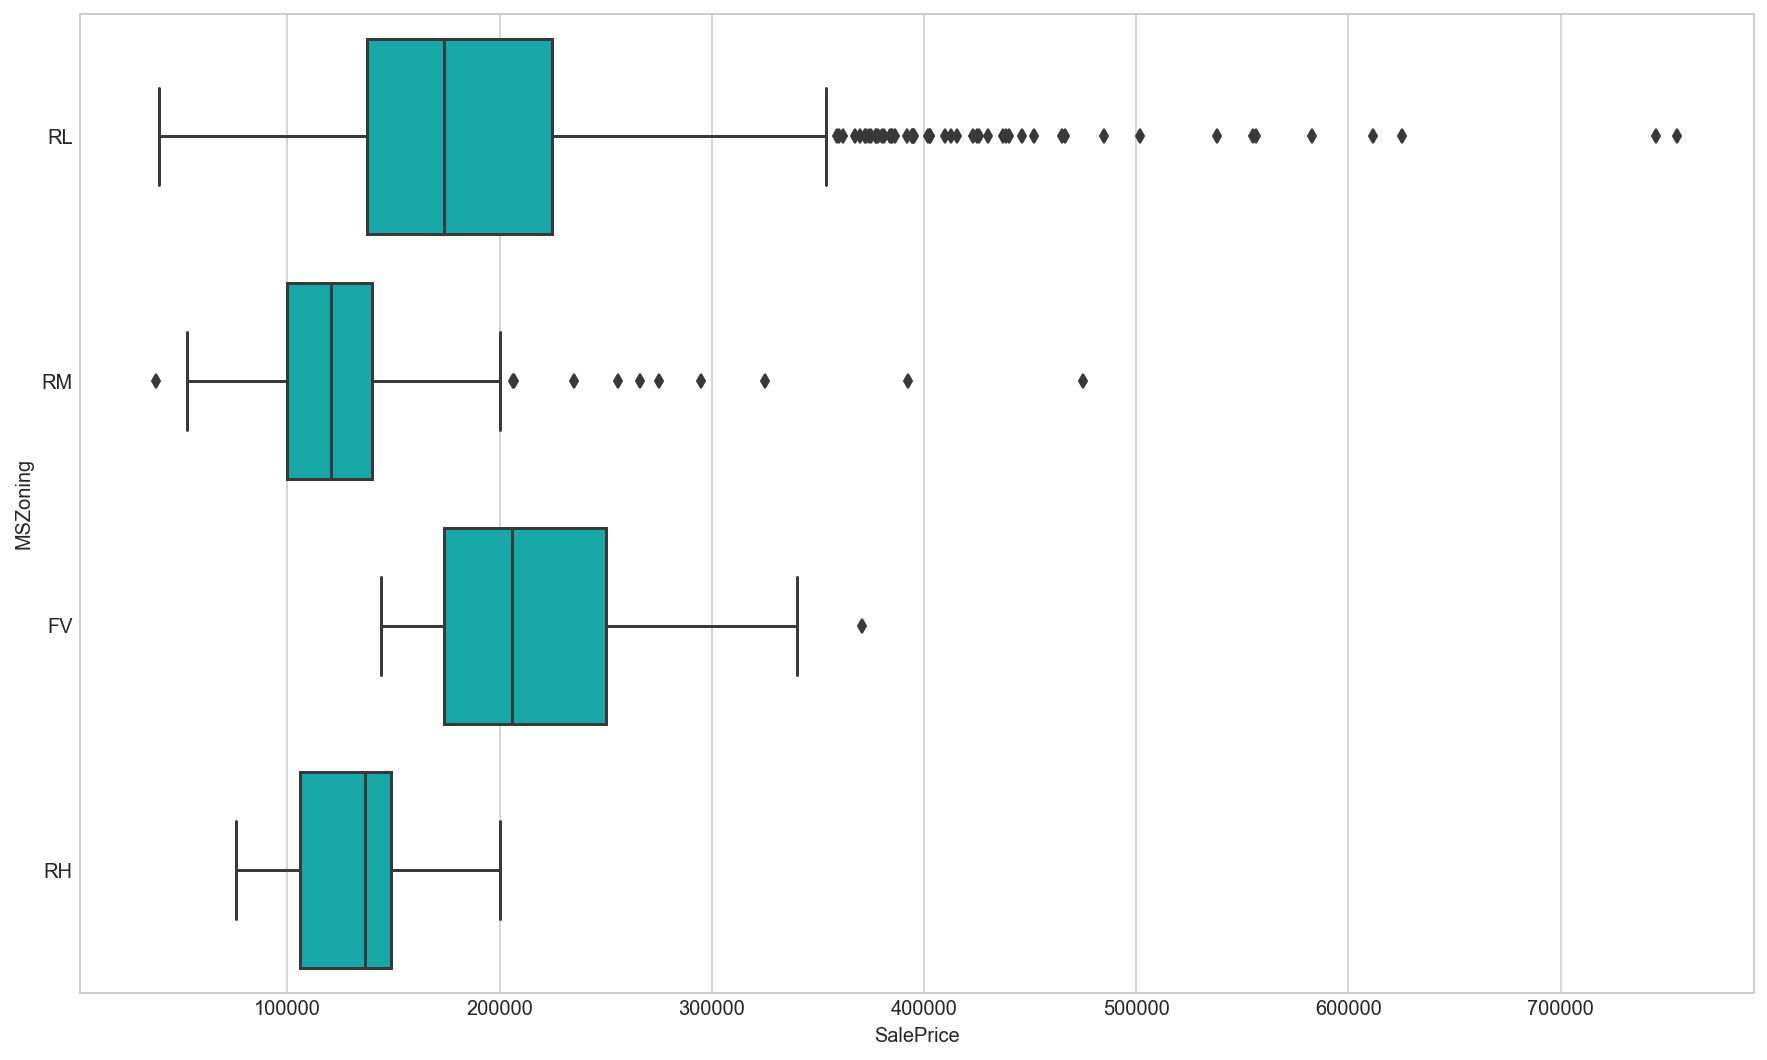

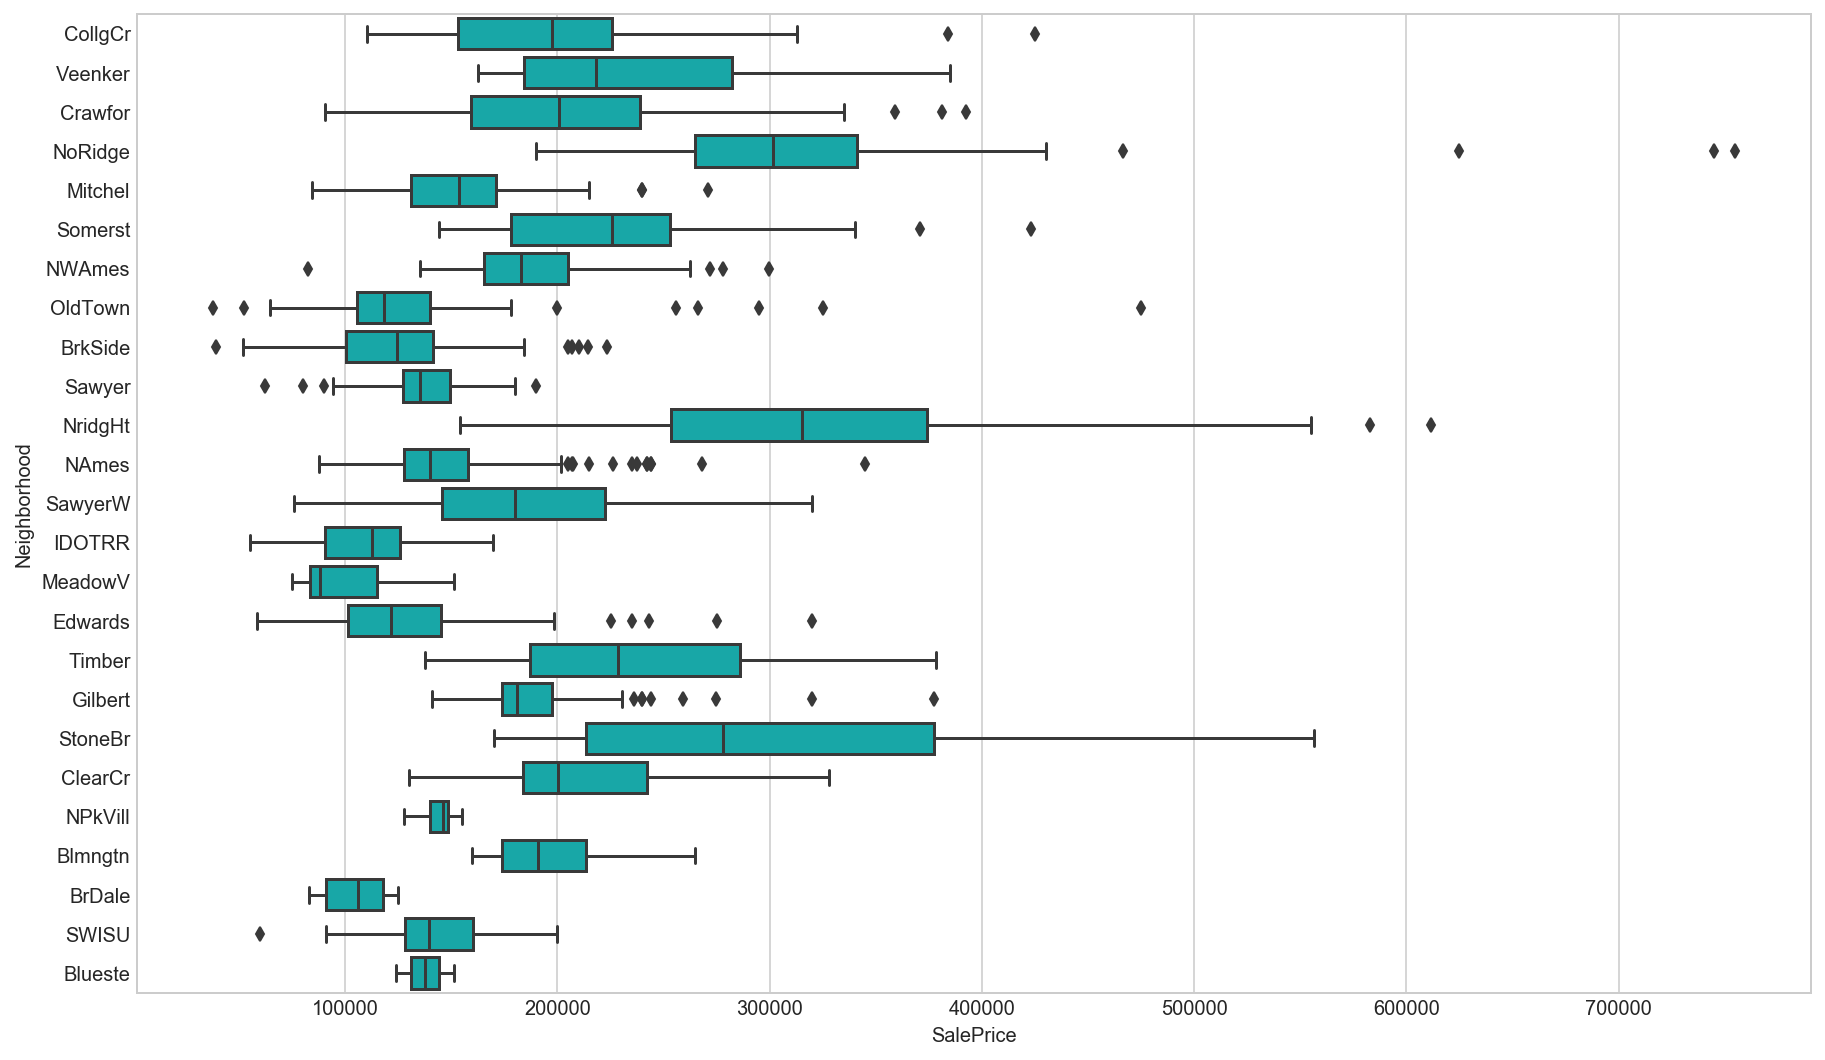

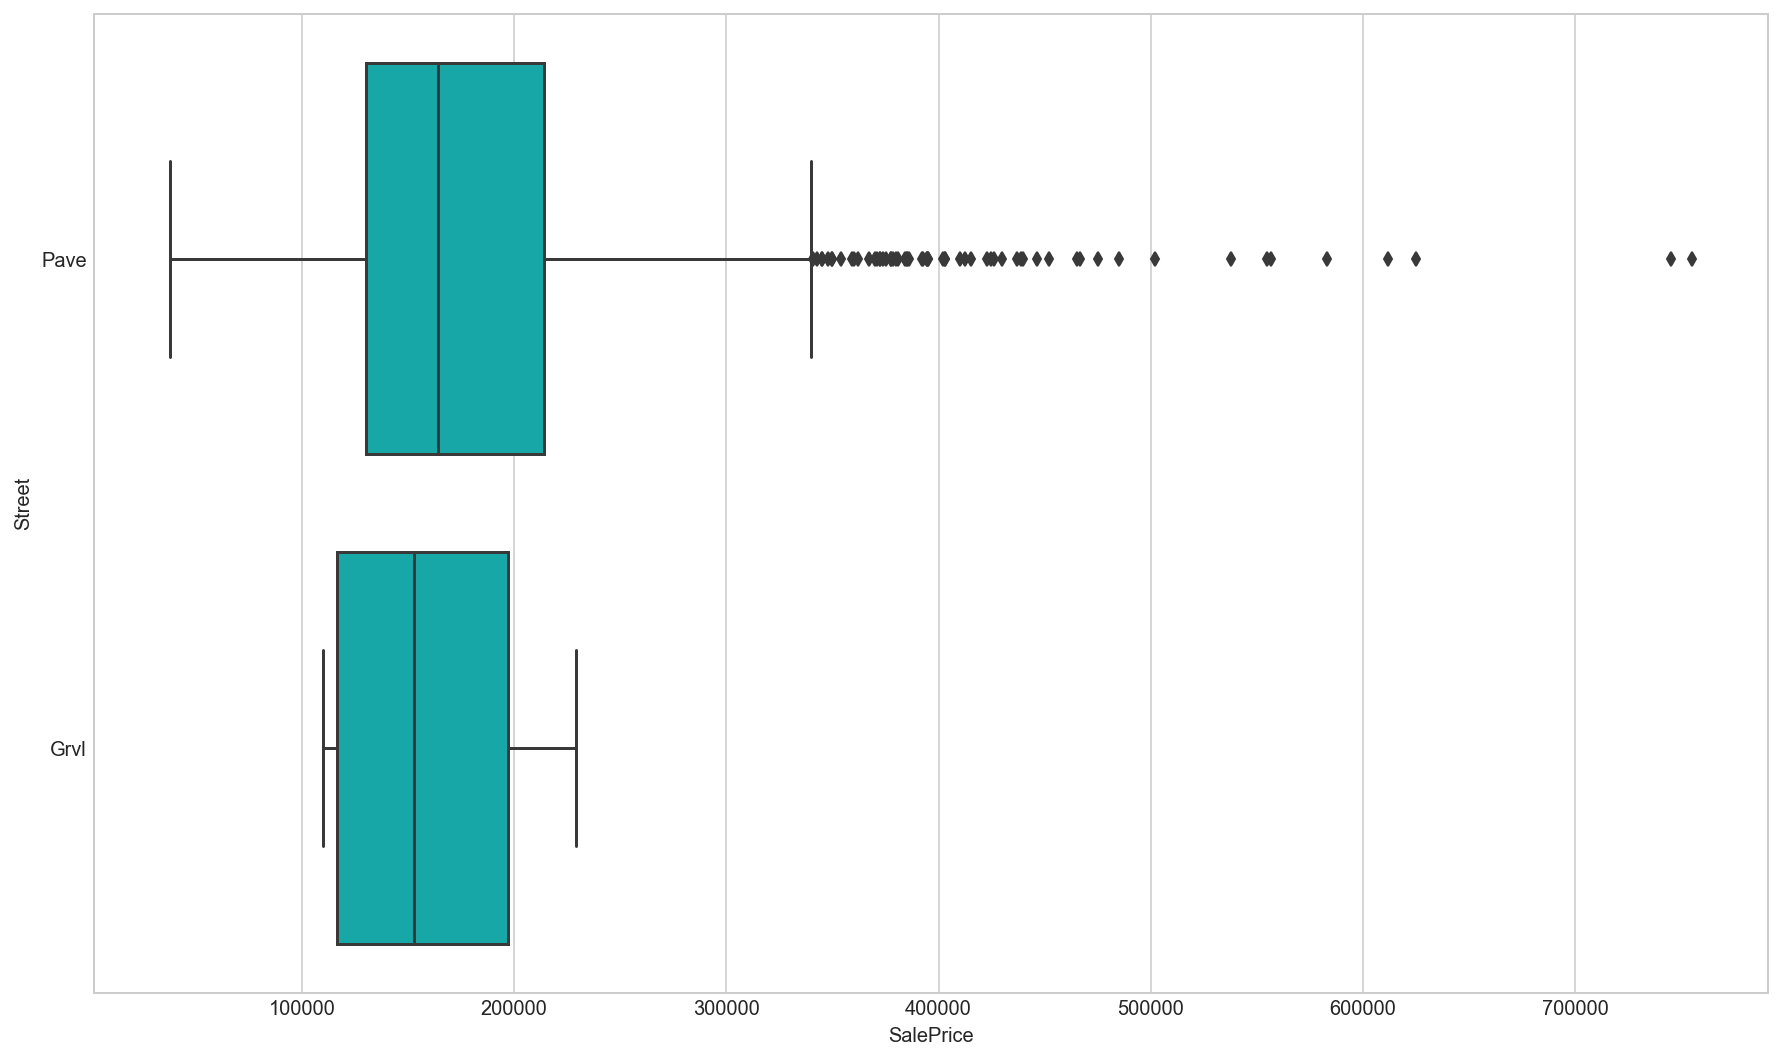

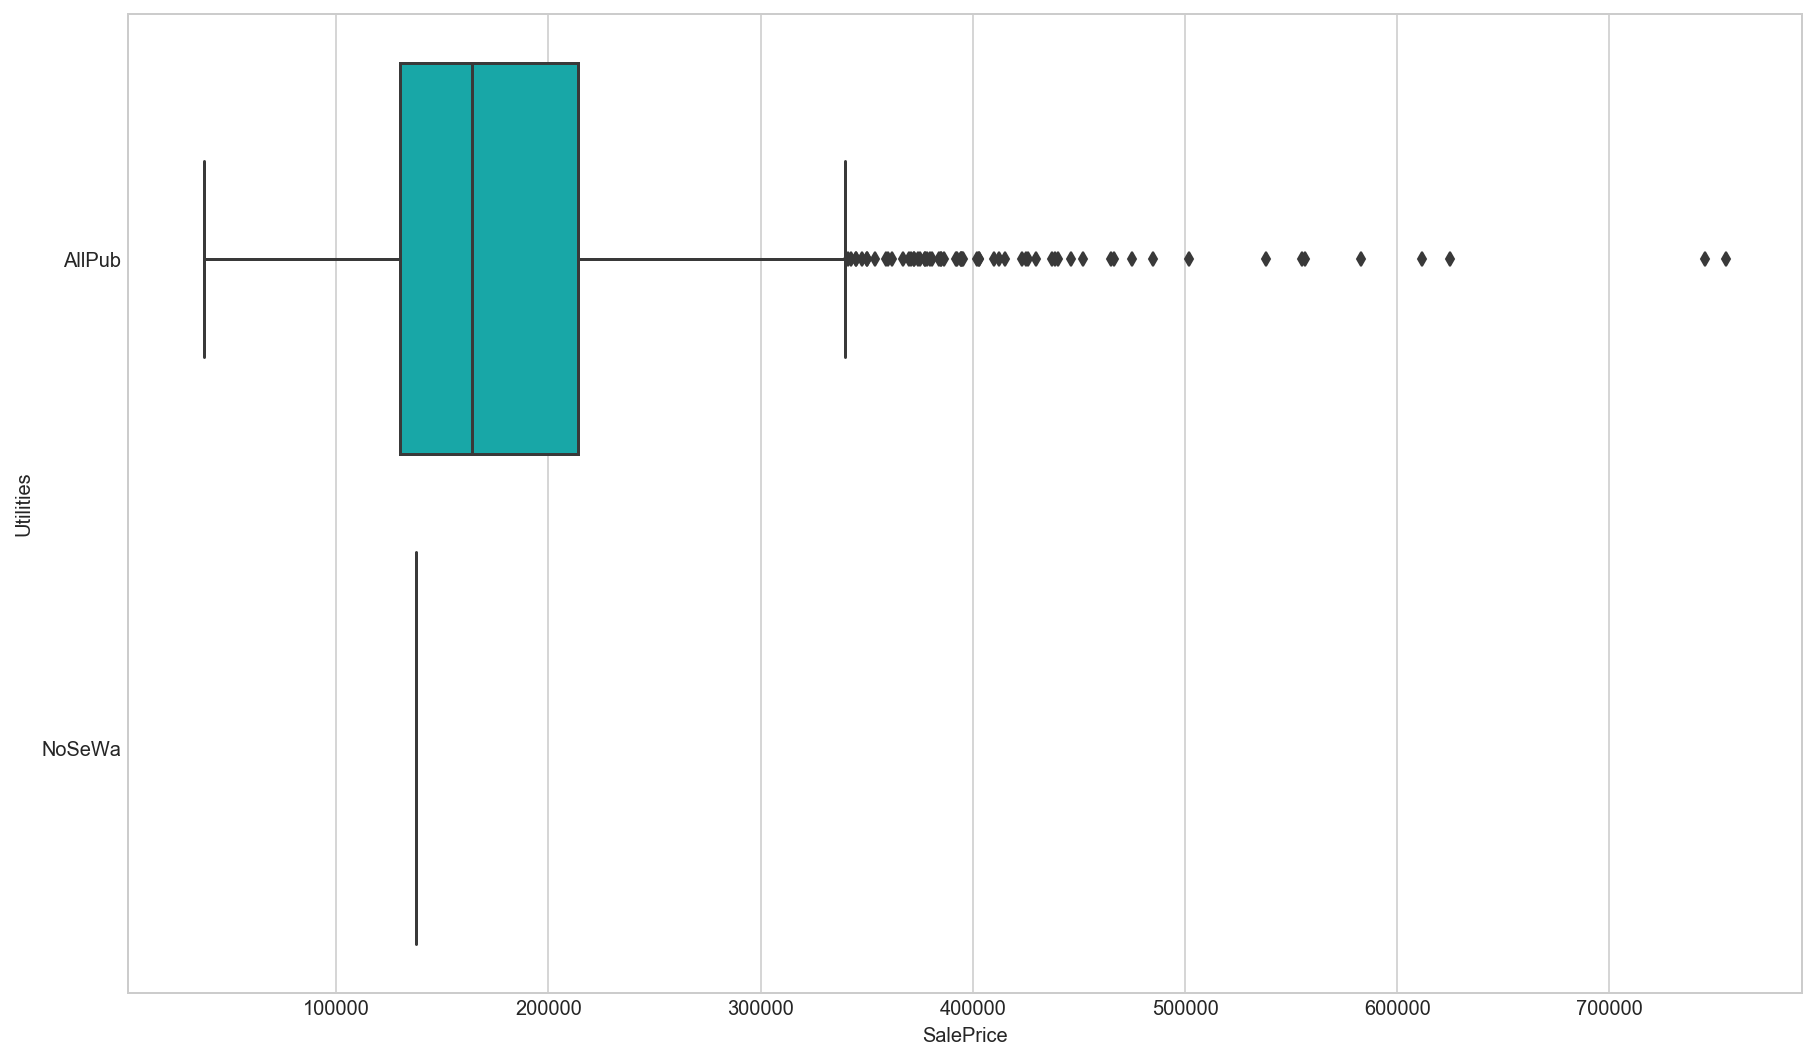

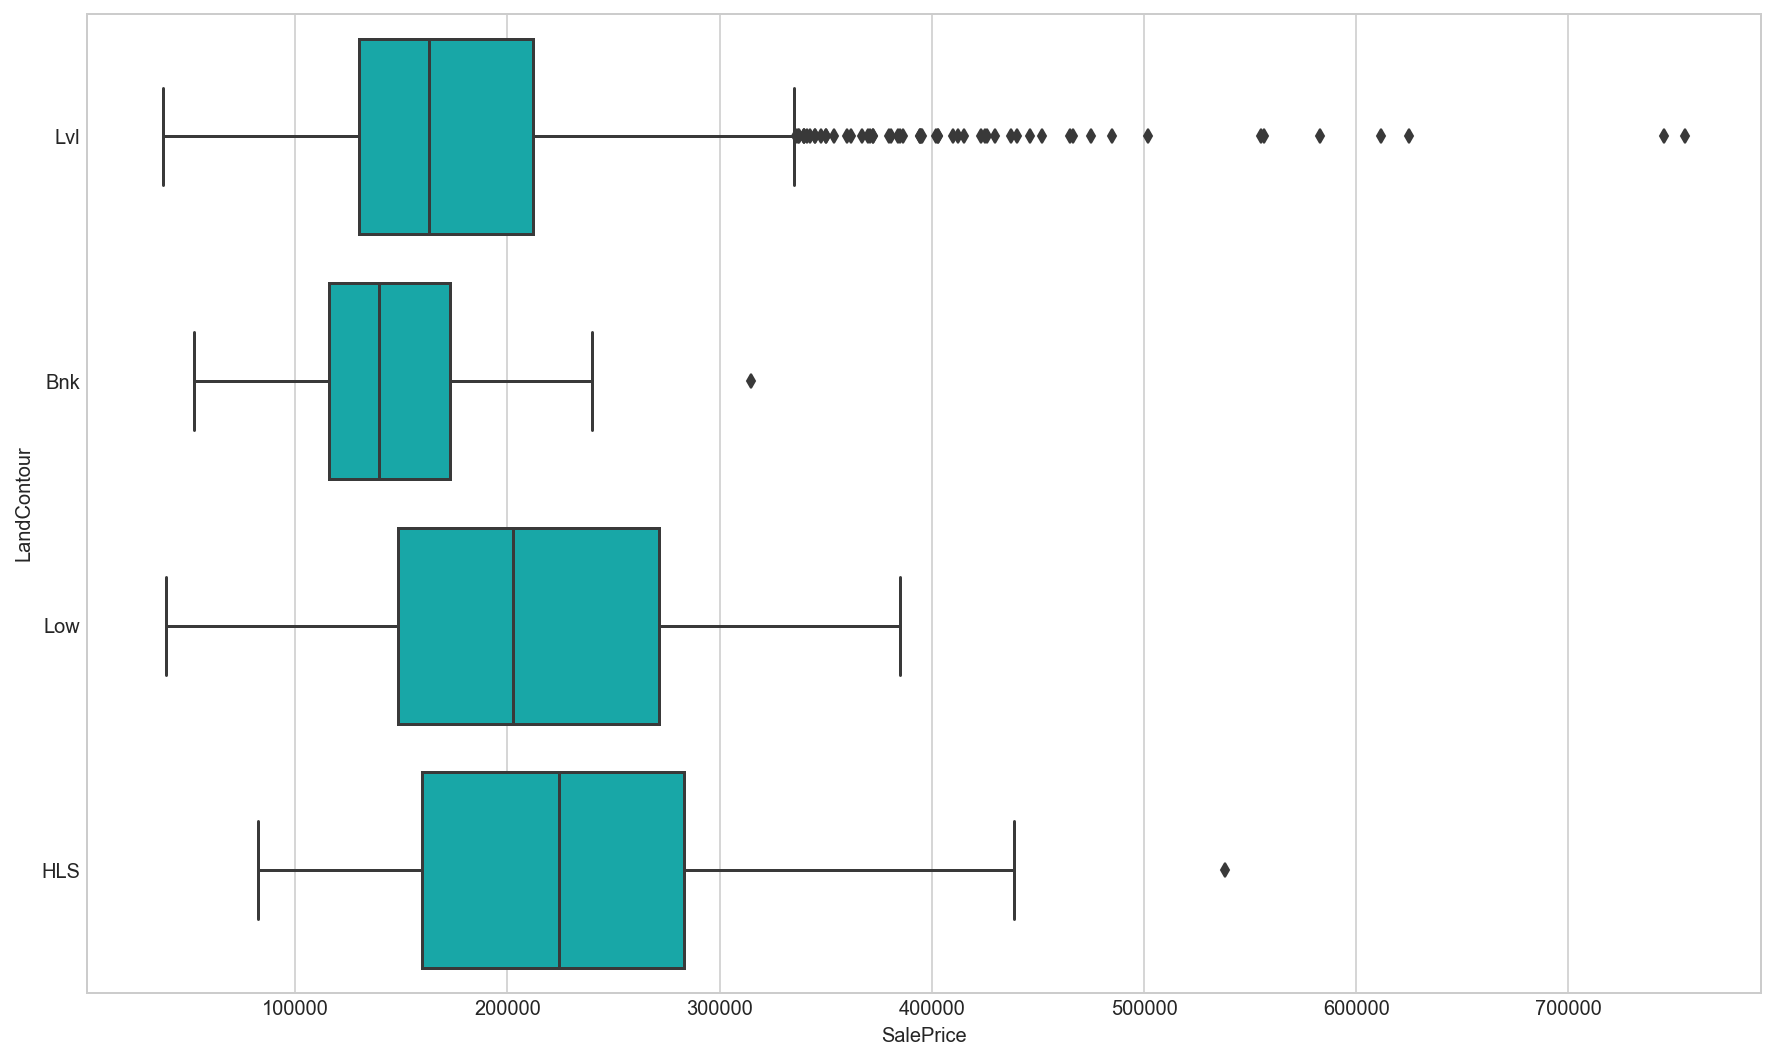

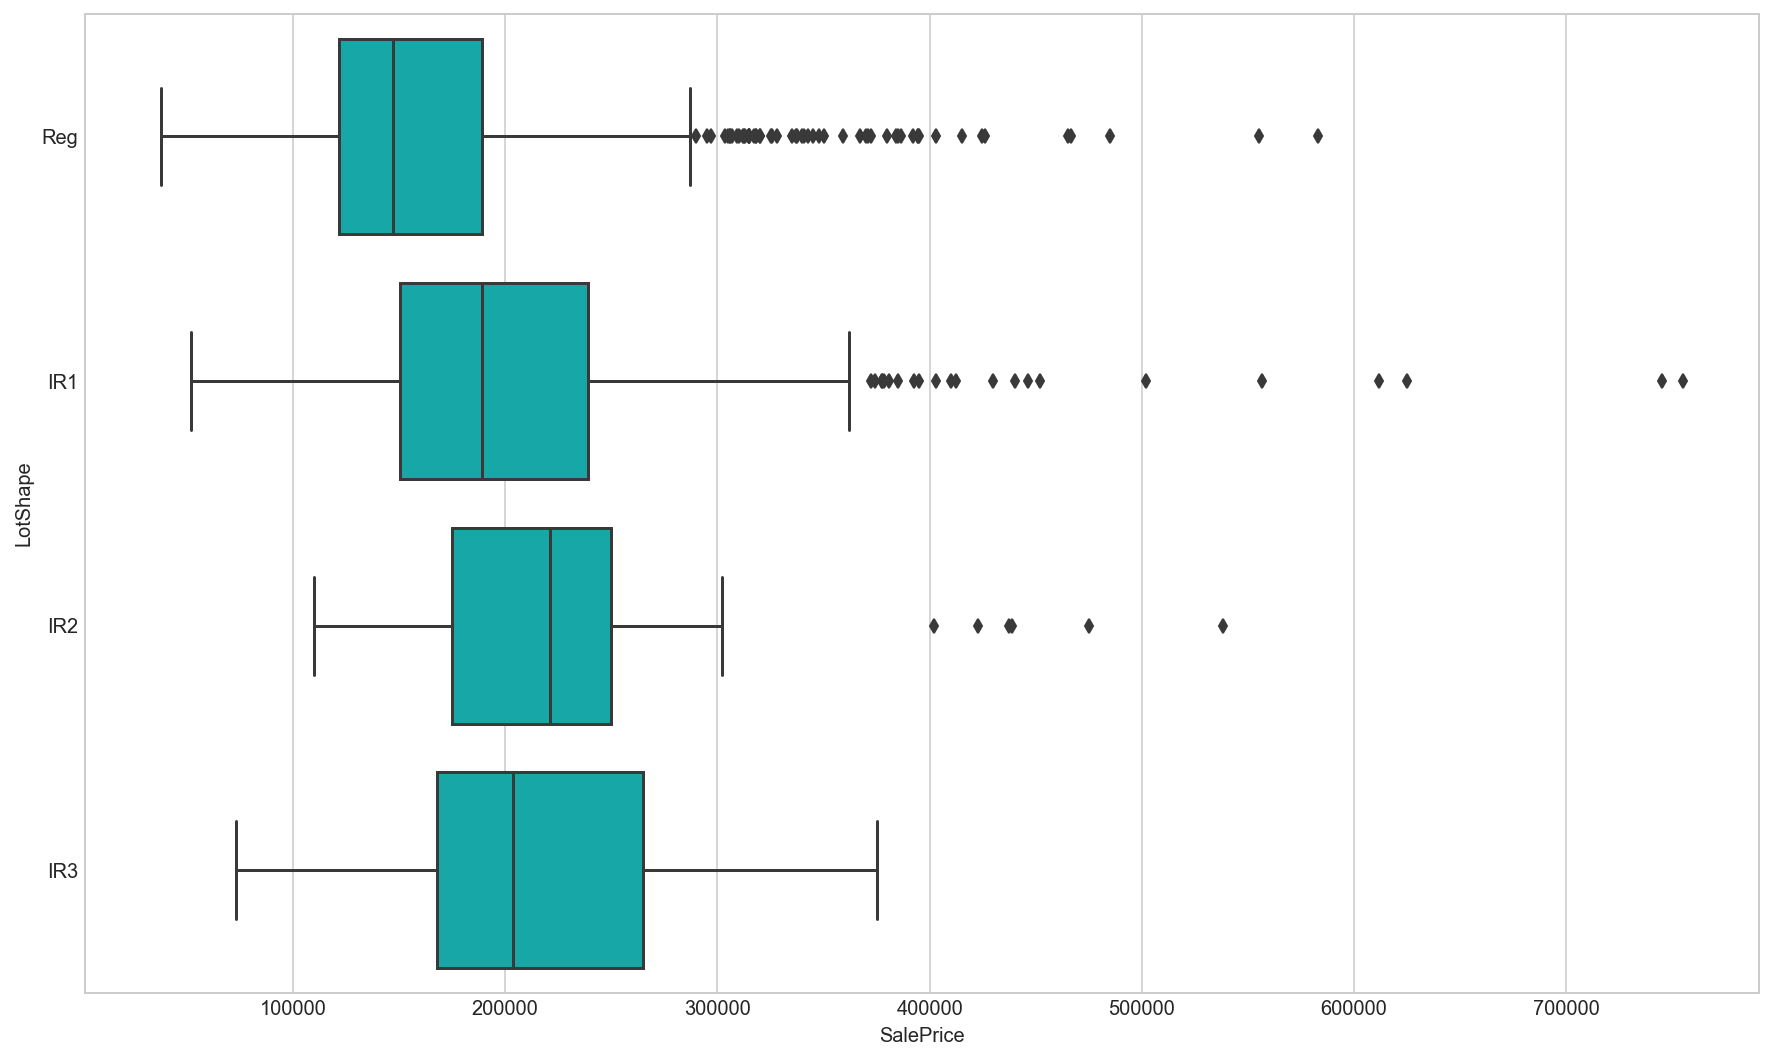

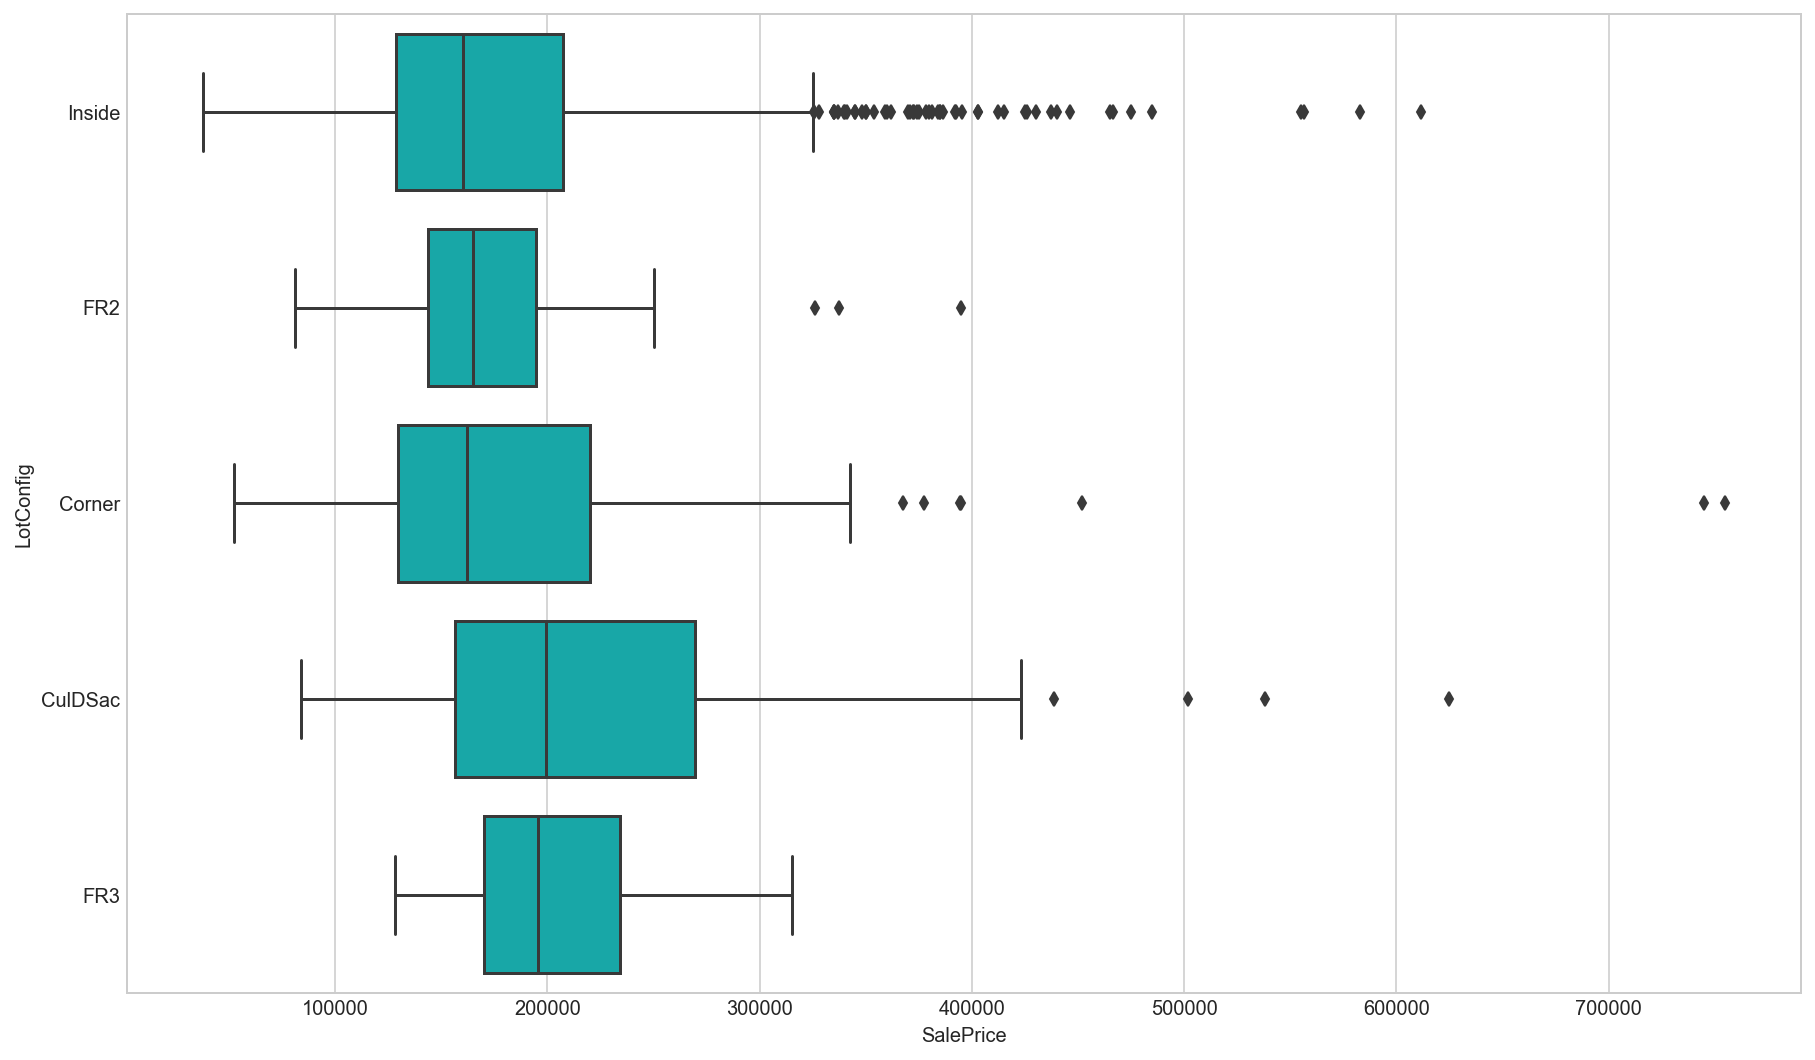

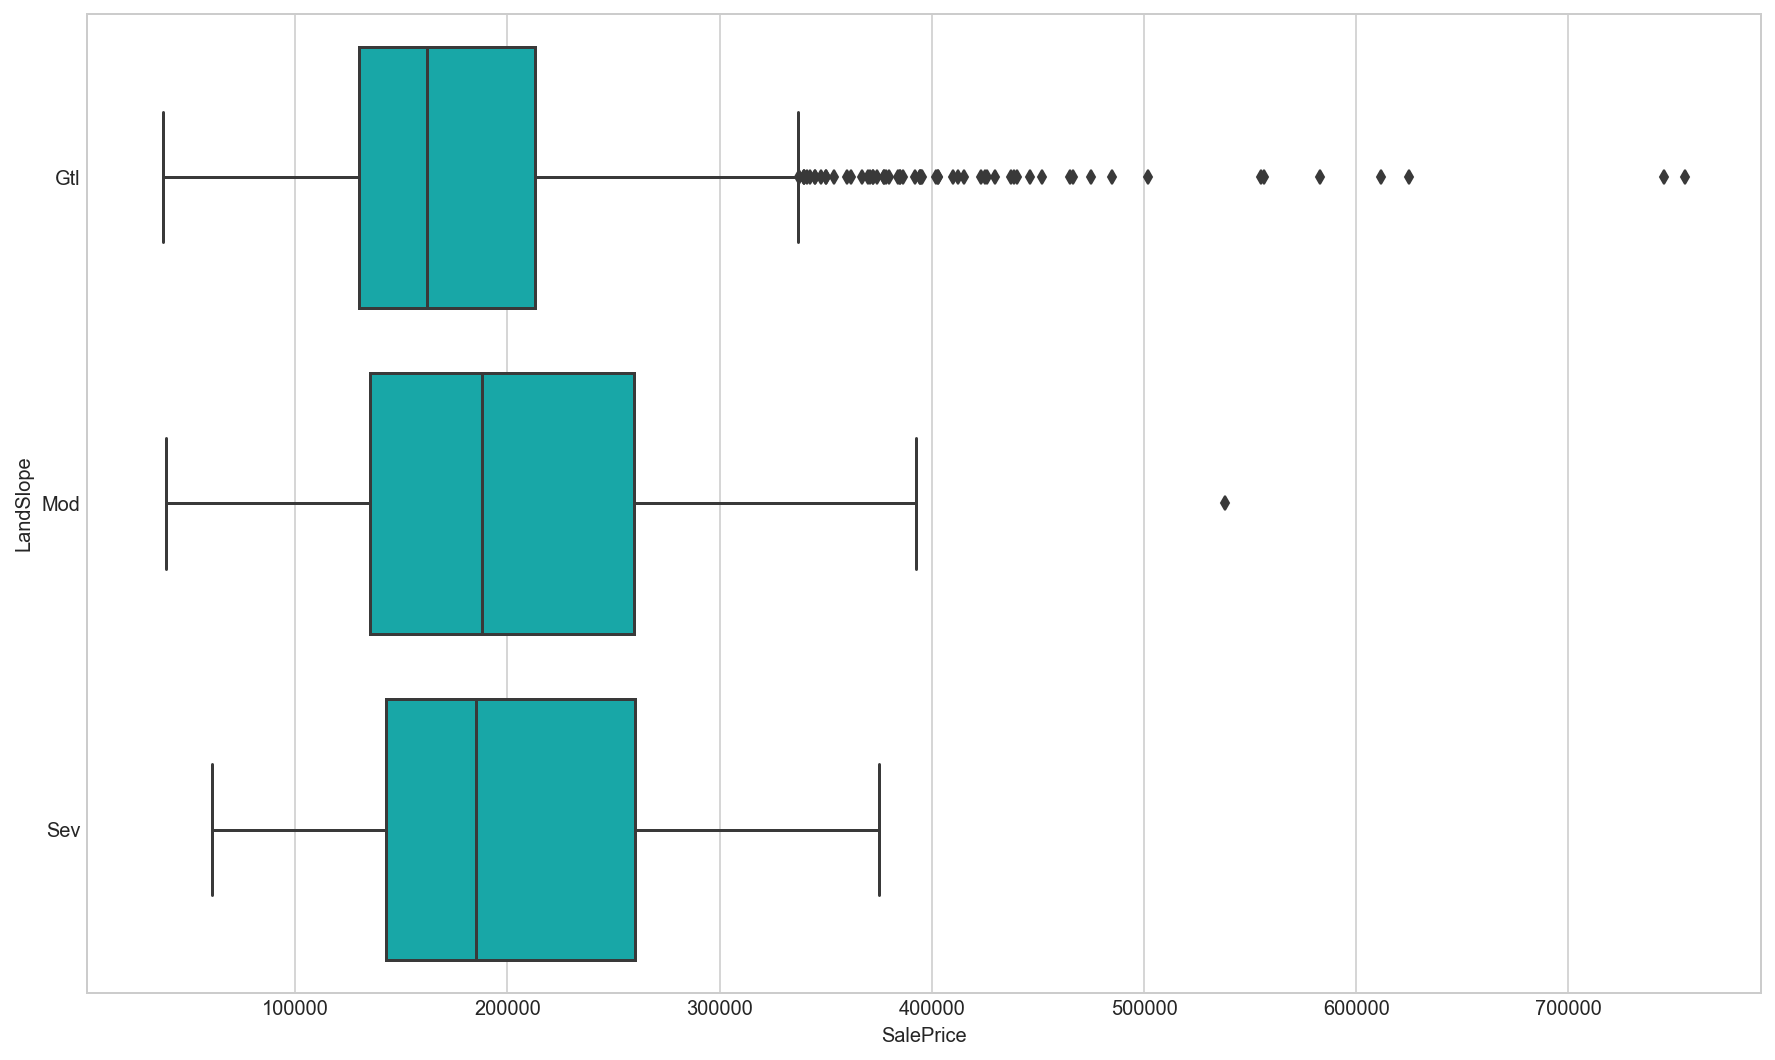

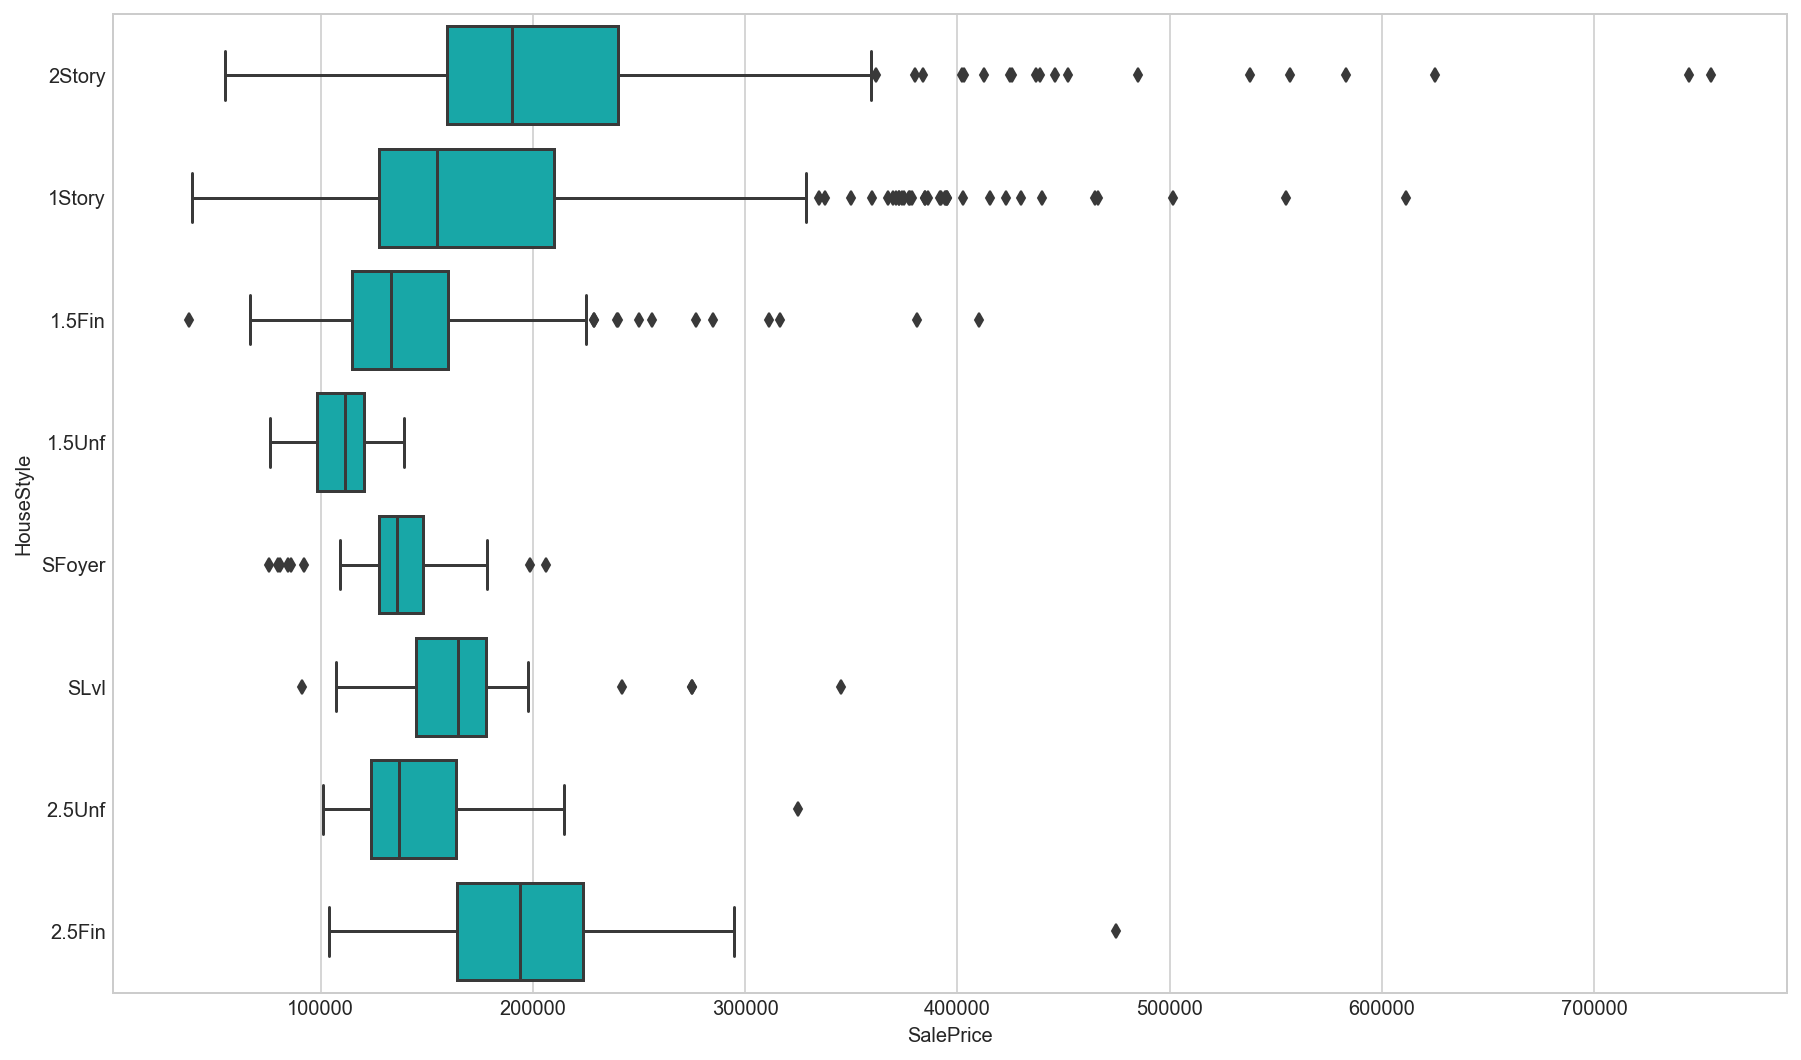

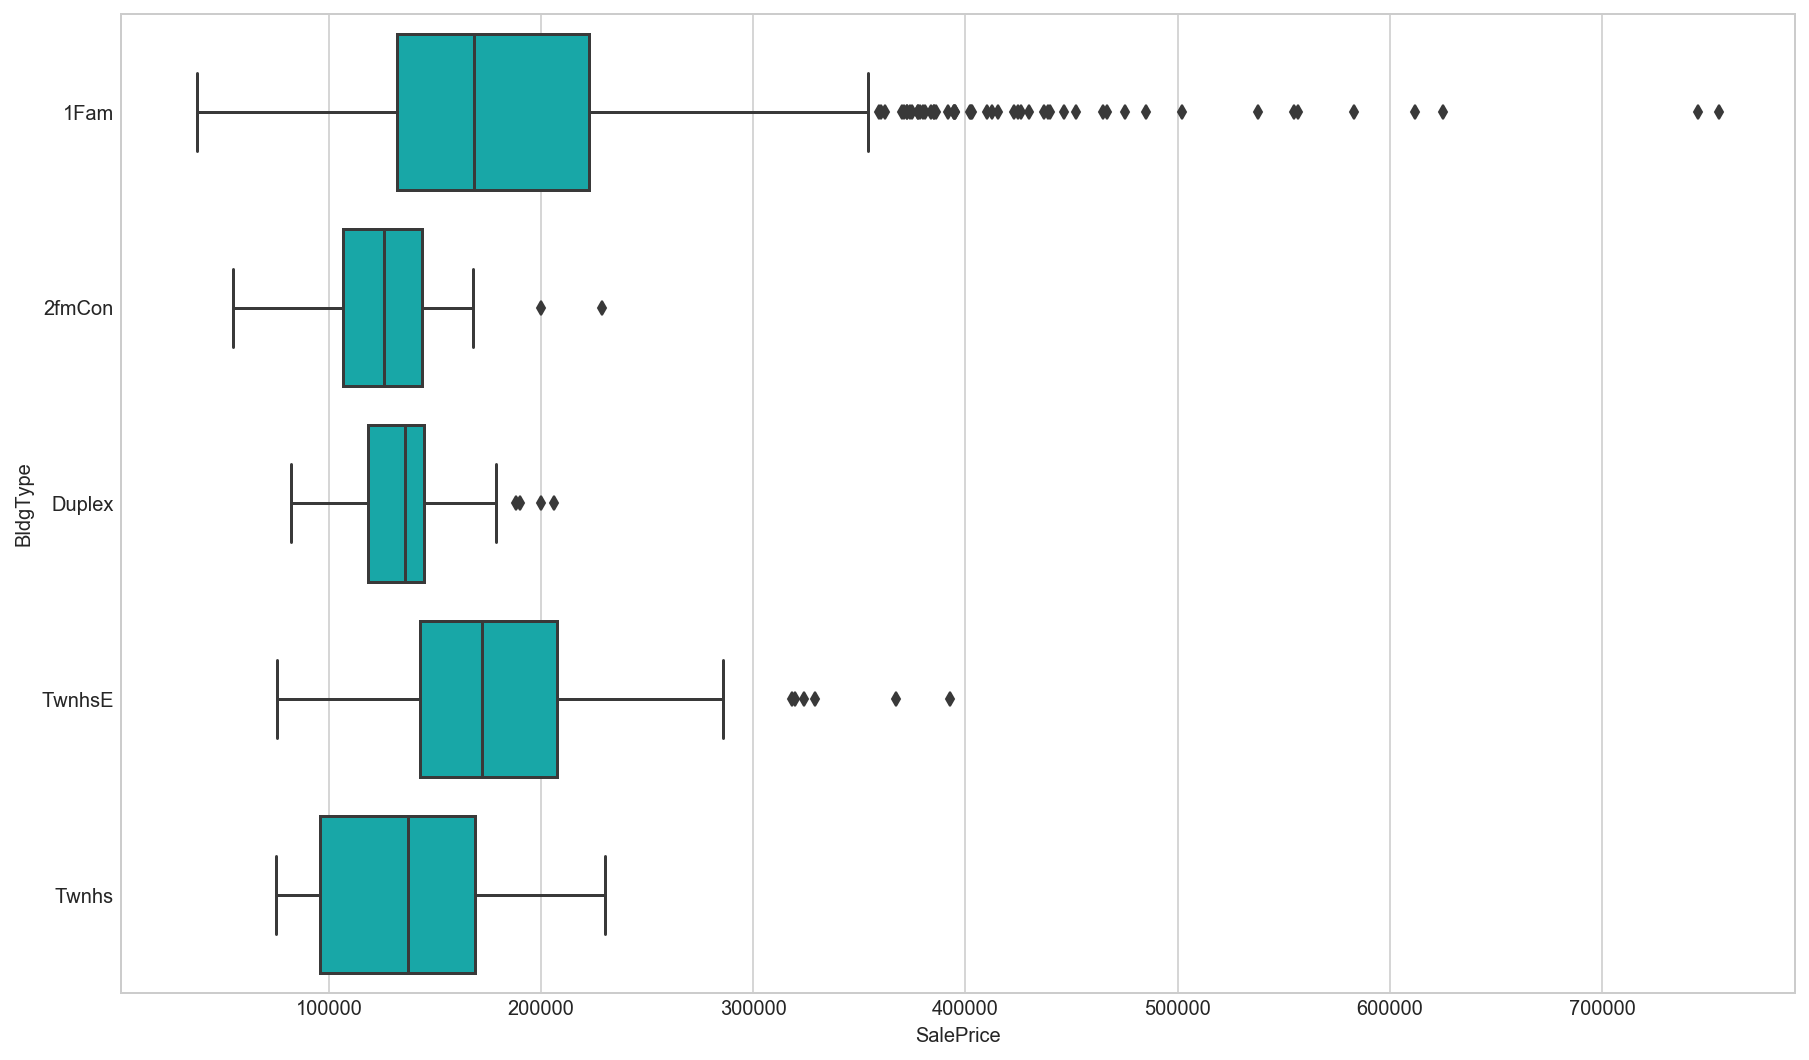

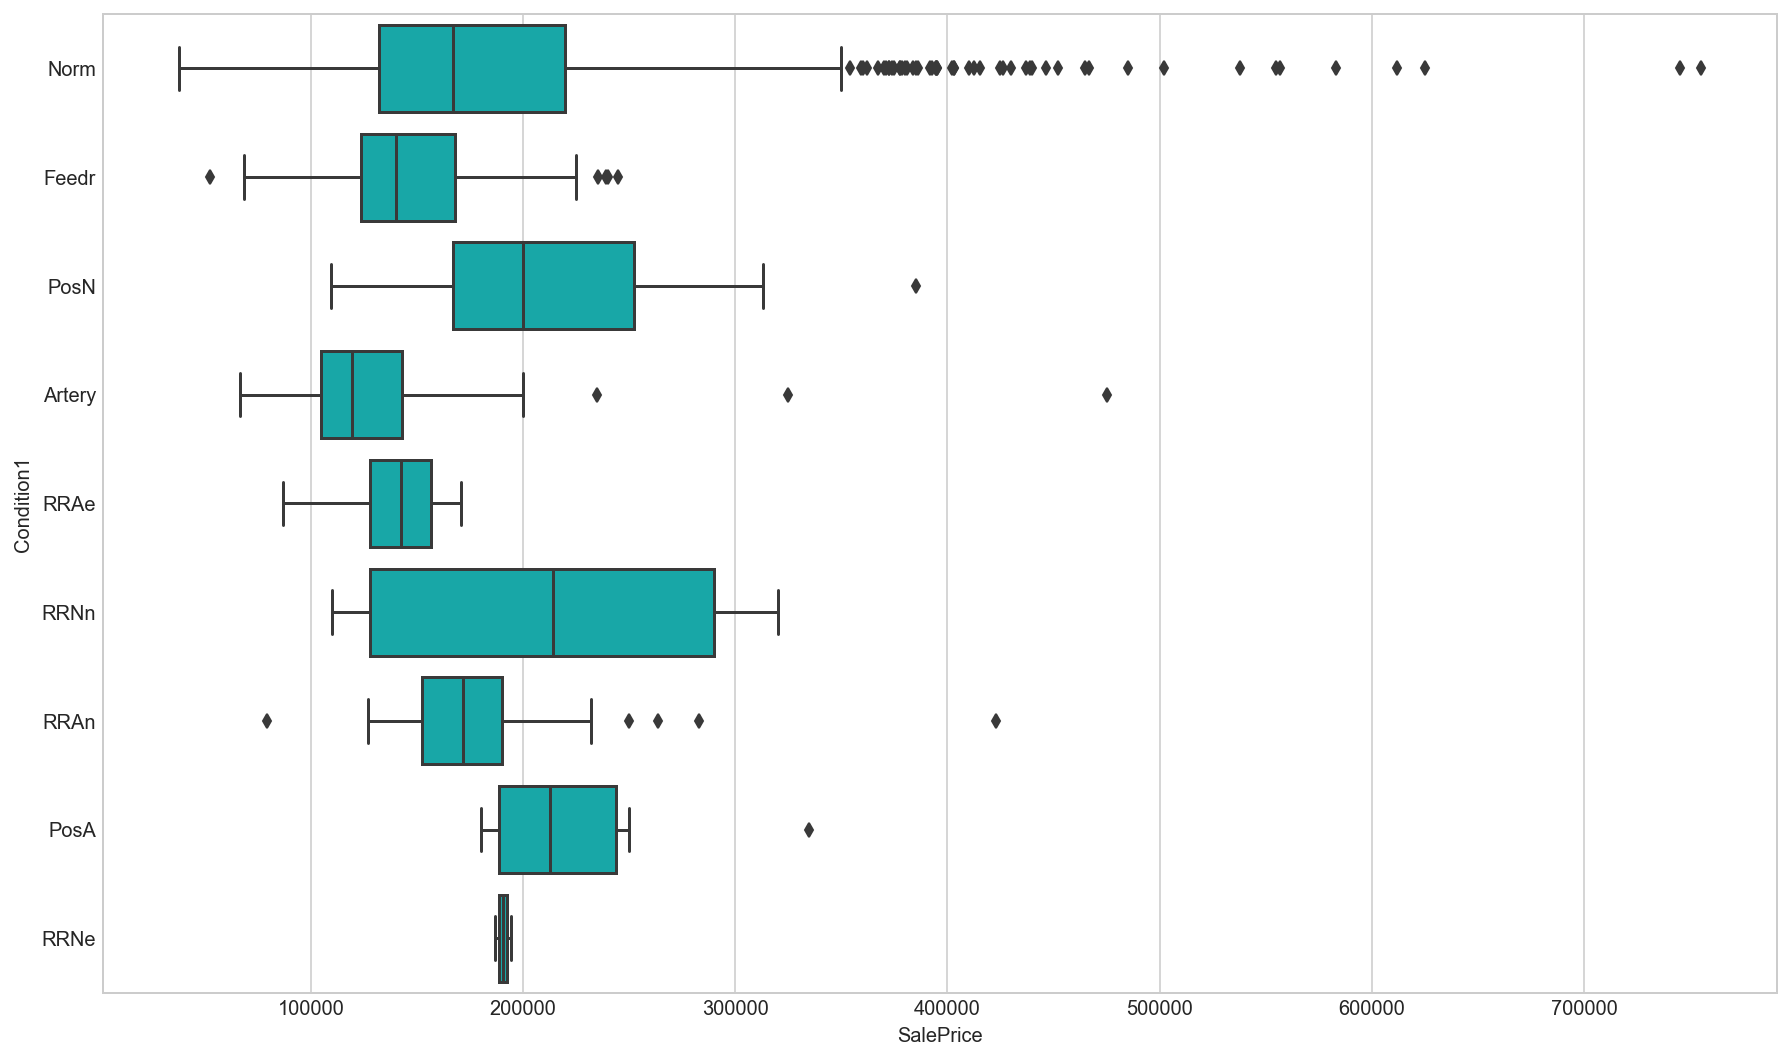

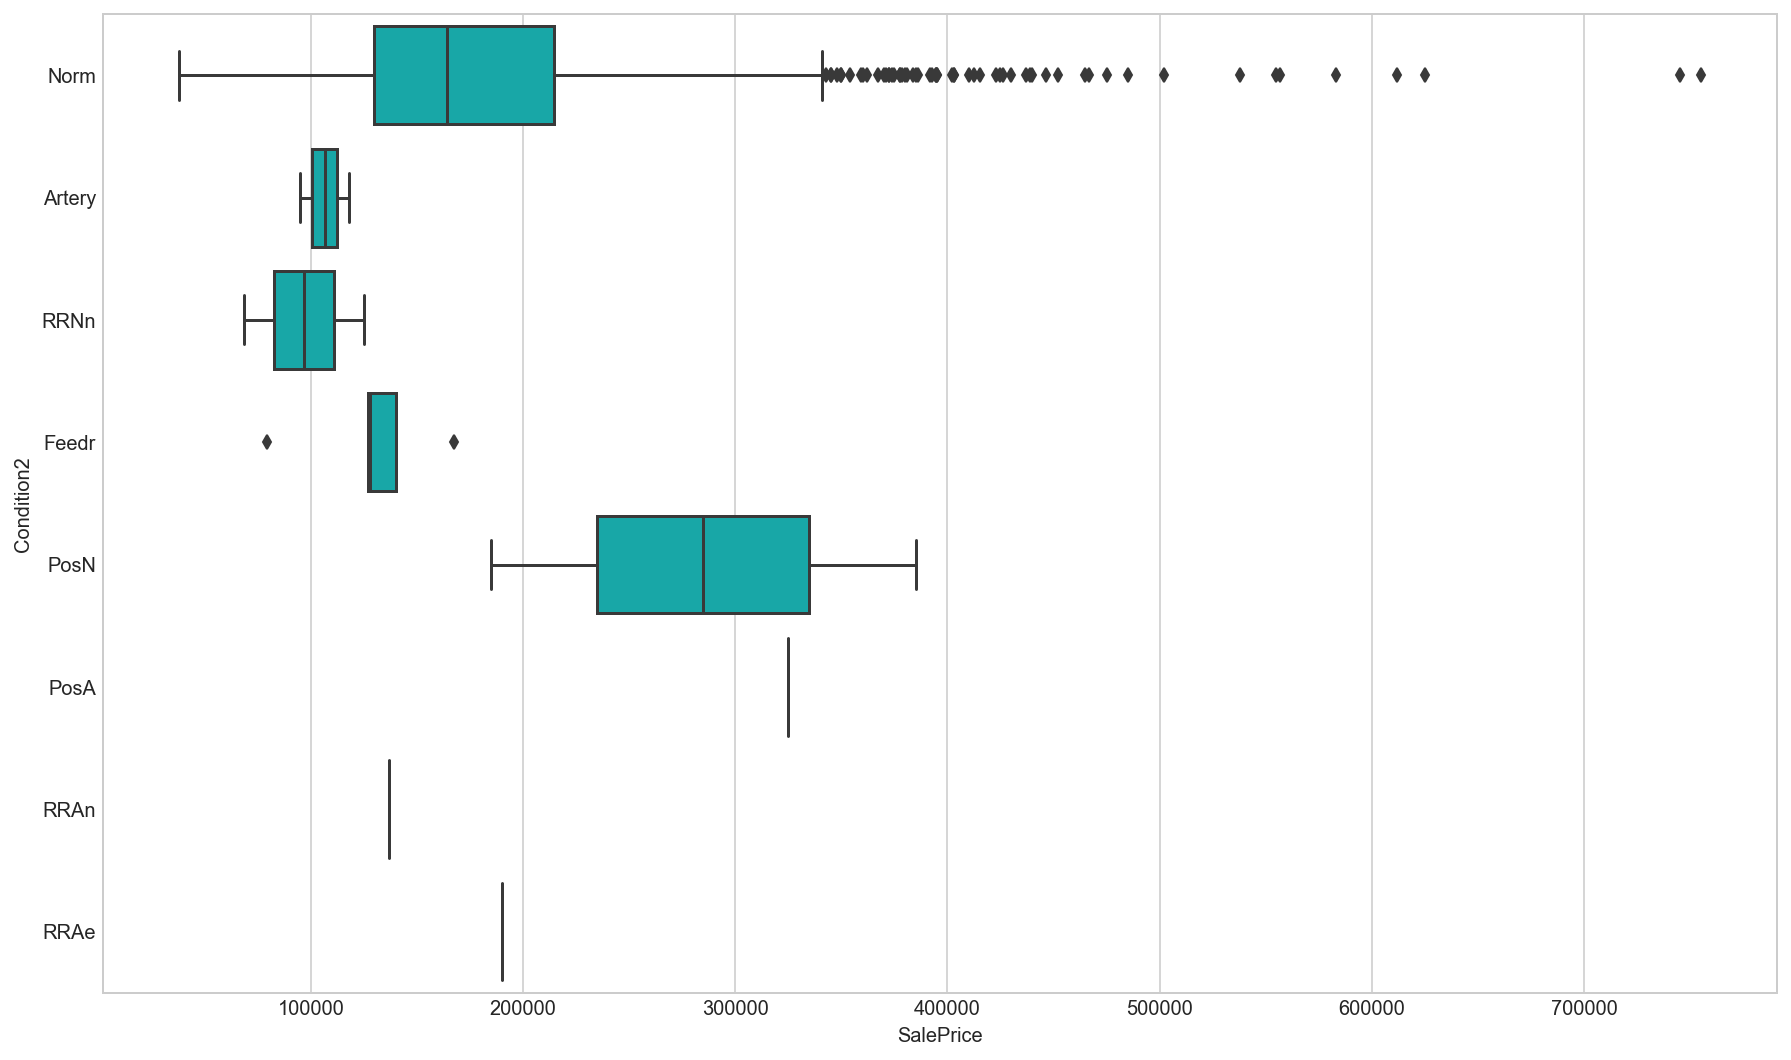

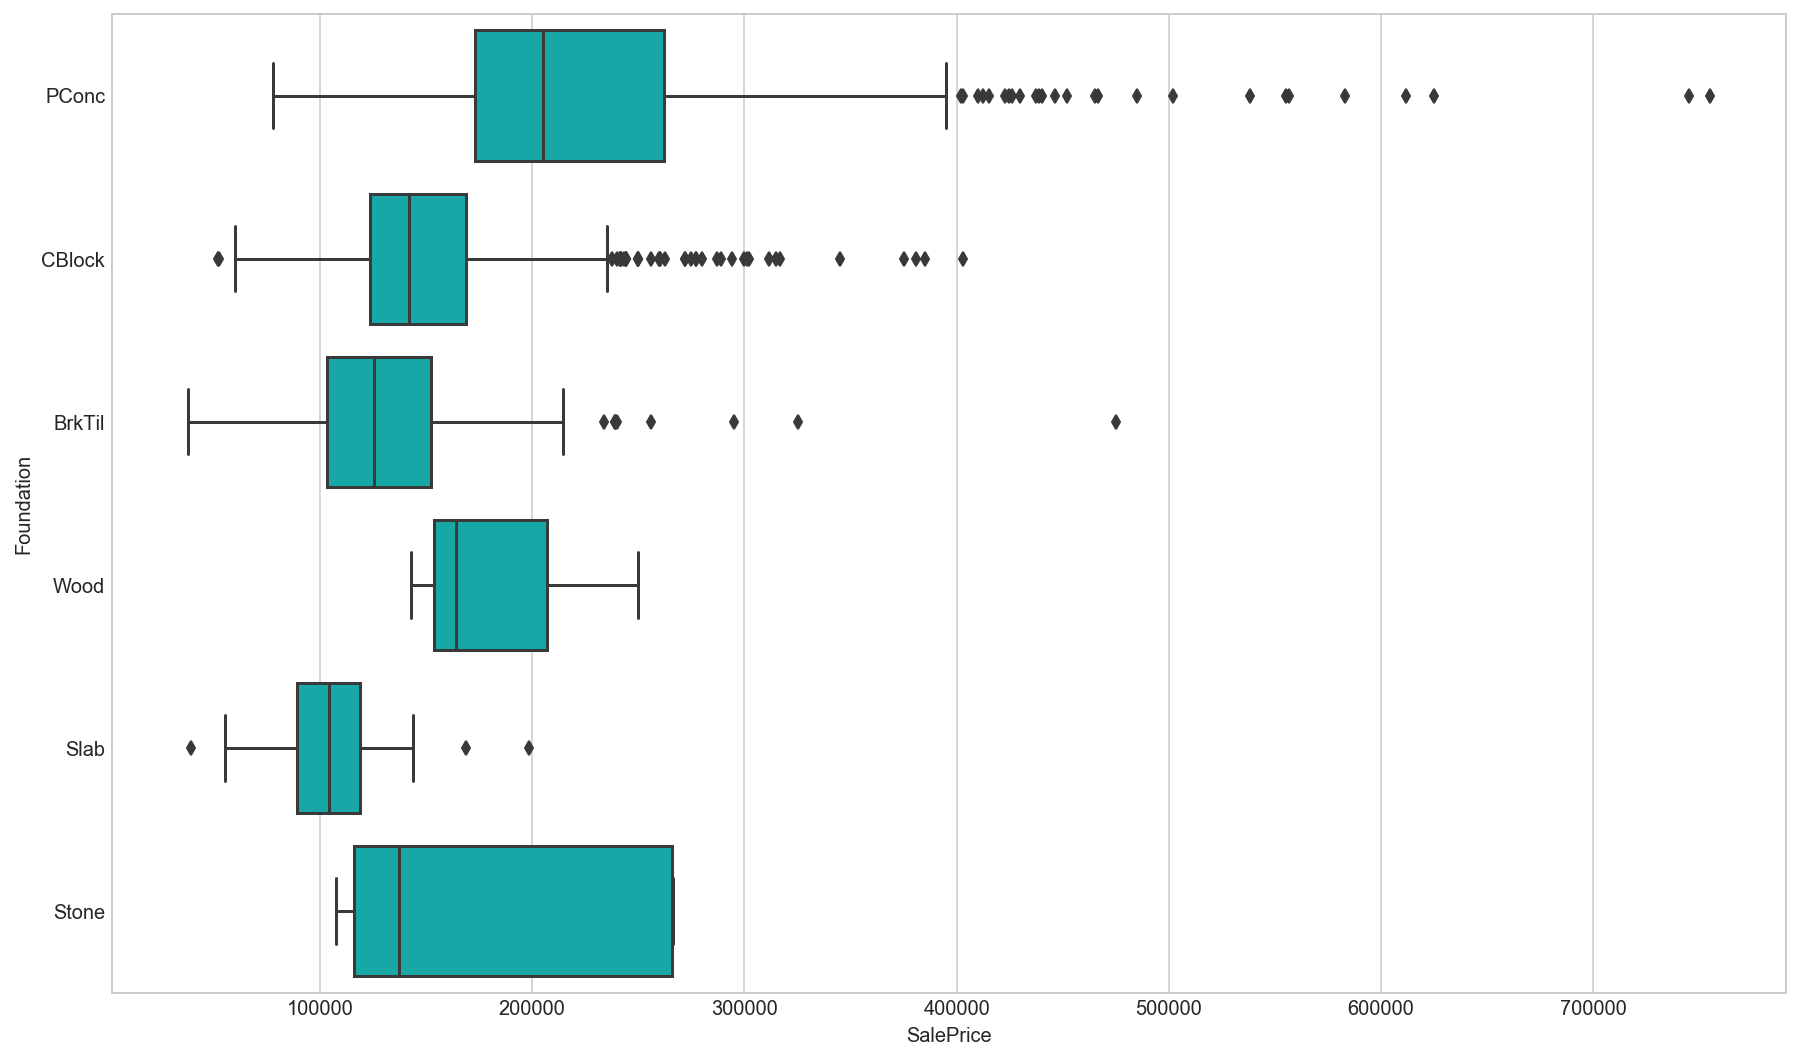

In [24]:
columns_to_analyze = ['MSZoning', 'Neighborhood', 'Street', 'Utilities', 
                      'LandContour', 'LotShape', 'LotConfig', 'LandSlope', 'HouseStyle', 
                      'BldgType', 'Condition1', 'Condition2', 'Foundation']
for column in columns_to_analyze:
    plt.figure(figsize=(15, 9))
    sns.boxplot(x='SalePrice', y=column, data=df_residental_house, color='c')
    plt.show()

In [25]:
df_residental_house[['LandSlope', 'SalePrice']].groupby('LandSlope').apply(lambda v: v.describe().T)

,,count,mean,std,min,25%,50%,75%,max
LandSlope,,,,,,,,,
Gtl,SalePrice,1375.0,180524.935273,78428.236874,37900.0,130000.0,162000.0,212950.0,755000.0
Mod,SalePrice,62.0,201950.806452,91250.694357,39300.0,135062.5,187850.0,259875.0,538000.0
Sev,SalePrice,13.0,204379.230769,86729.922409,61000.0,143000.0,185000.0,260000.0,375000.0


In [26]:
df_residental_house['Age_at_sale'] = df_residental_house['YrSold'] - df_residental_house['YearBuilt']

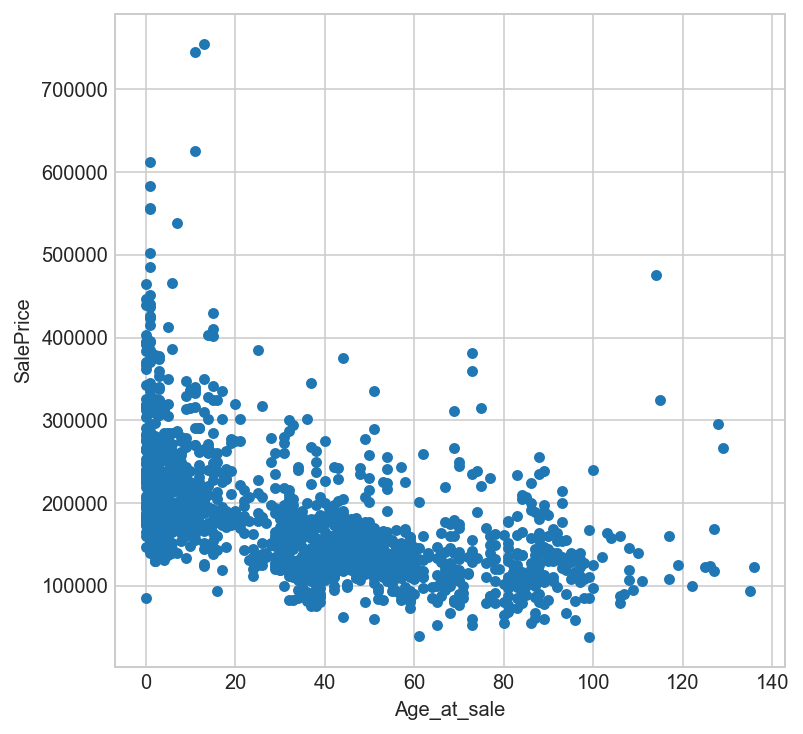

In [27]:
df_residental_house[['Age_at_sale', 'SalePrice']].plot.scatter(x='Age_at_sale', y='SalePrice', figsize=(6, 6))
plt.show()

In [28]:
df_residental_house[['Age_at_sale', 'SalePrice']].corr()

,Age_at_sale,SalePrice
Age_at_sale,1.00000,-0.51801
SalePrice,-0.51801,1.00000


In [29]:
# Understand availability of proximity of various conditions
set(df_residental_house[df_residental_house['Condition1'] == df_residental_house['Condition2']]['Condition1'])

{'Artery', 'Norm', 'PosN'}

In [30]:
df_residental_house.loc[(df_residental_house['Condition1'] == 'PosA') | (df_residental_house['Condition2'] == 'PosA'), ['Condition1', 'Condition2']]

,Condition1,Condition2
66,PosA,Norm
293,PosA,Norm
446,PosA,Norm
471,PosA,Norm
583,Artery,PosA
859,PosA,Norm
934,PosA,Norm
997,PosA,Norm
1310,PosA,Norm


In [31]:
# Provide score for proximity of significant features
df_residental_house['NSRailRoad_proximity_score'] = df_residental_house.apply(lambda c: 2 if c['Condition1'] == 'RRAn' or c['Condition2'] == 'RRAn' \
                                                                                          else 1 if c['Condition1'] == 'RRNn' or c['Condition2'] == 'RRNn' \
                                                                                          else 0,
                                                                                          axis = 1)
df_residental_house['EWRailRoad_proximity_score'] = df_residental_house.apply(lambda c: 2 if c['Condition1'] == 'RRAe' or c['Condition2'] == 'RRAe' \
                                                                                          else 1 if c['Condition1'] == 'RRNe' or c['Condition2'] == 'RRNe' \
                                                                                          else 0,
                                                                                          axis = 1)
df_residental_house['PositiveOffSiteFeature_proximity_score'] = df_residental_house.apply(lambda c: 2 if c['Condition1'] == 'PosA' or c['Condition2'] == 'PosN' \
                                                                                          else 1 if c['Condition1'] == 'PosN' or c['Condition2'] == 'PosN' \
                                                                                          else 0,
                                                                                          axis = 1)

In [32]:
# Convert LandContour to code, as they can influence price.
df_residental_house['LandContourCode'] = df_residental_house['LandContour'].map(lambda v: 3 if v == 'HLS' else 2 if v == 'Low' else 1 if v == 'Lvl' else 0)

In [33]:
# Get total sq ft of the house.
df_residental_house['TotalSF'] = df_residental_house['GrLivArea'] + df_residental_house['TotalBsmtSF']

In [34]:
# Get dummies for features that are presented as ordinals
df_zone = pd.get_dummies(df_residental_house['MSZoning'], prefix='Zone', drop_first=True)
df_lotshape = pd.get_dummies(df_residental_house['LotShape'], prefix='LotShape', drop_first=True)
df_lotConfig = pd.get_dummies(df_residental_house['LotConfig'], prefix='LotConfig', drop_first=True)


df_residental_house = pd.concat([df_residental_house, df_zone, df_lotshape, df_lotConfig], axis=1)

In [35]:
df_residental_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Zone_RH,Zone_RL,Zone_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,1,0,0,0,1,0,0,0,1
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,1,0,0,0,1,0,1,0,0
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,1,0,0,0,0,0,0,0,1
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,1,0,0,0,0,0,0,0,0
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,1,0,0,0,0,0,1,0,0


In [36]:
df_residental_house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [37]:
# Select non-renovable features that can predict price.
column_X = ['LotArea', 'LandContourCode', 'NSRailRoad_proximity_score', 
            'EWRailRoad_proximity_score', 'PositiveOffSiteFeature_proximity_score', 'TotalBsmtSF', 
            'TotalSF', 'TotRmsAbvGrd', 'BsmtFullBath', 'BsmtHalfBath', 
            'FullBath', 'HalfBath', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Age_at_sale', 
            'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
            'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside']

In [38]:
# Split data set into training and test set.
y_train = df_residental_house.loc[df_residental_house['YrSold'] < 2010, 'SalePrice'].copy()
y_test = df_residental_house.loc[df_residental_house['YrSold'] == 2010, 'SalePrice'].copy()
X_train = df_residental_house.loc[df_residental_house['YrSold'] < 2010, column_X].copy()
X_test = df_residental_house.loc[df_residental_house['YrSold'] == 2010, column_X].copy()

In [39]:
# Do standard scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [40]:
# Train using regression with ElasticNet with 6-fold (about 200 per fold) cross-validation and test
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=6)
optimal_enet.fit(Xs_train, y_train)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)

print ("Score with training set: {}".format(optimal_enet.score(Xs_train, y_train)))
print ("Score with test set: {}".format(optimal_enet.score(Xs_test, y_test)))

806.895549508528
1.0
Score with training set: 0.73036727708
Score with test set: 0.784117539564


In [41]:
optimal_enet.coef_

array([  1916.01560086,   4345.42023998,     -0.        ,  -2818.74197663,
        -2531.93339351,  -8819.47718595,  48590.32178233,   1392.98812275,
         3715.91813469,      0.        ,   3323.51488006,   1725.52005566,
        12685.59021194,   4433.50224962,   1246.59658107,    700.2955554 ,
          648.01323002,   3604.21533707,  -1258.87403501, -16569.28051305,
         1266.63725557,  -4013.4629633 ,  -1184.739541  ,   2179.74513126,
         -155.00524426,      0.        ,      0.        ])

In [42]:
# Determine the features that can affect price.
[feature for (feature, coef) in zip(column_X, optimal_enet.coef_.tolist()) if coef != 0]

['LotArea',
 'LandContourCode',
 'EWRailRoad_proximity_score',
 'PositiveOffSiteFeature_proximity_score',
 'TotalBsmtSF',
 'TotalSF',
 'TotRmsAbvGrd',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Age_at_sale',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LotConfig_CulDSac',
 'LotConfig_FR2']

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [43]:
df_residental_house['RenovablePriceDiff'] = df_residental_house['SalePrice'] - optimal_enet.predict(df_residental_house[column_X])

In [44]:
df_residental_house[['RenovablePriceDiff']].describe()

,RenovablePriceDiff
count,1.450000e+03
mean,-1.420139e+08
std,4.823969e+07
min,-6.583021e+08
25%,-1.658300e+08
50%,-1.348149e+08
75%,-1.114106e+08
max,-2.495482e+07


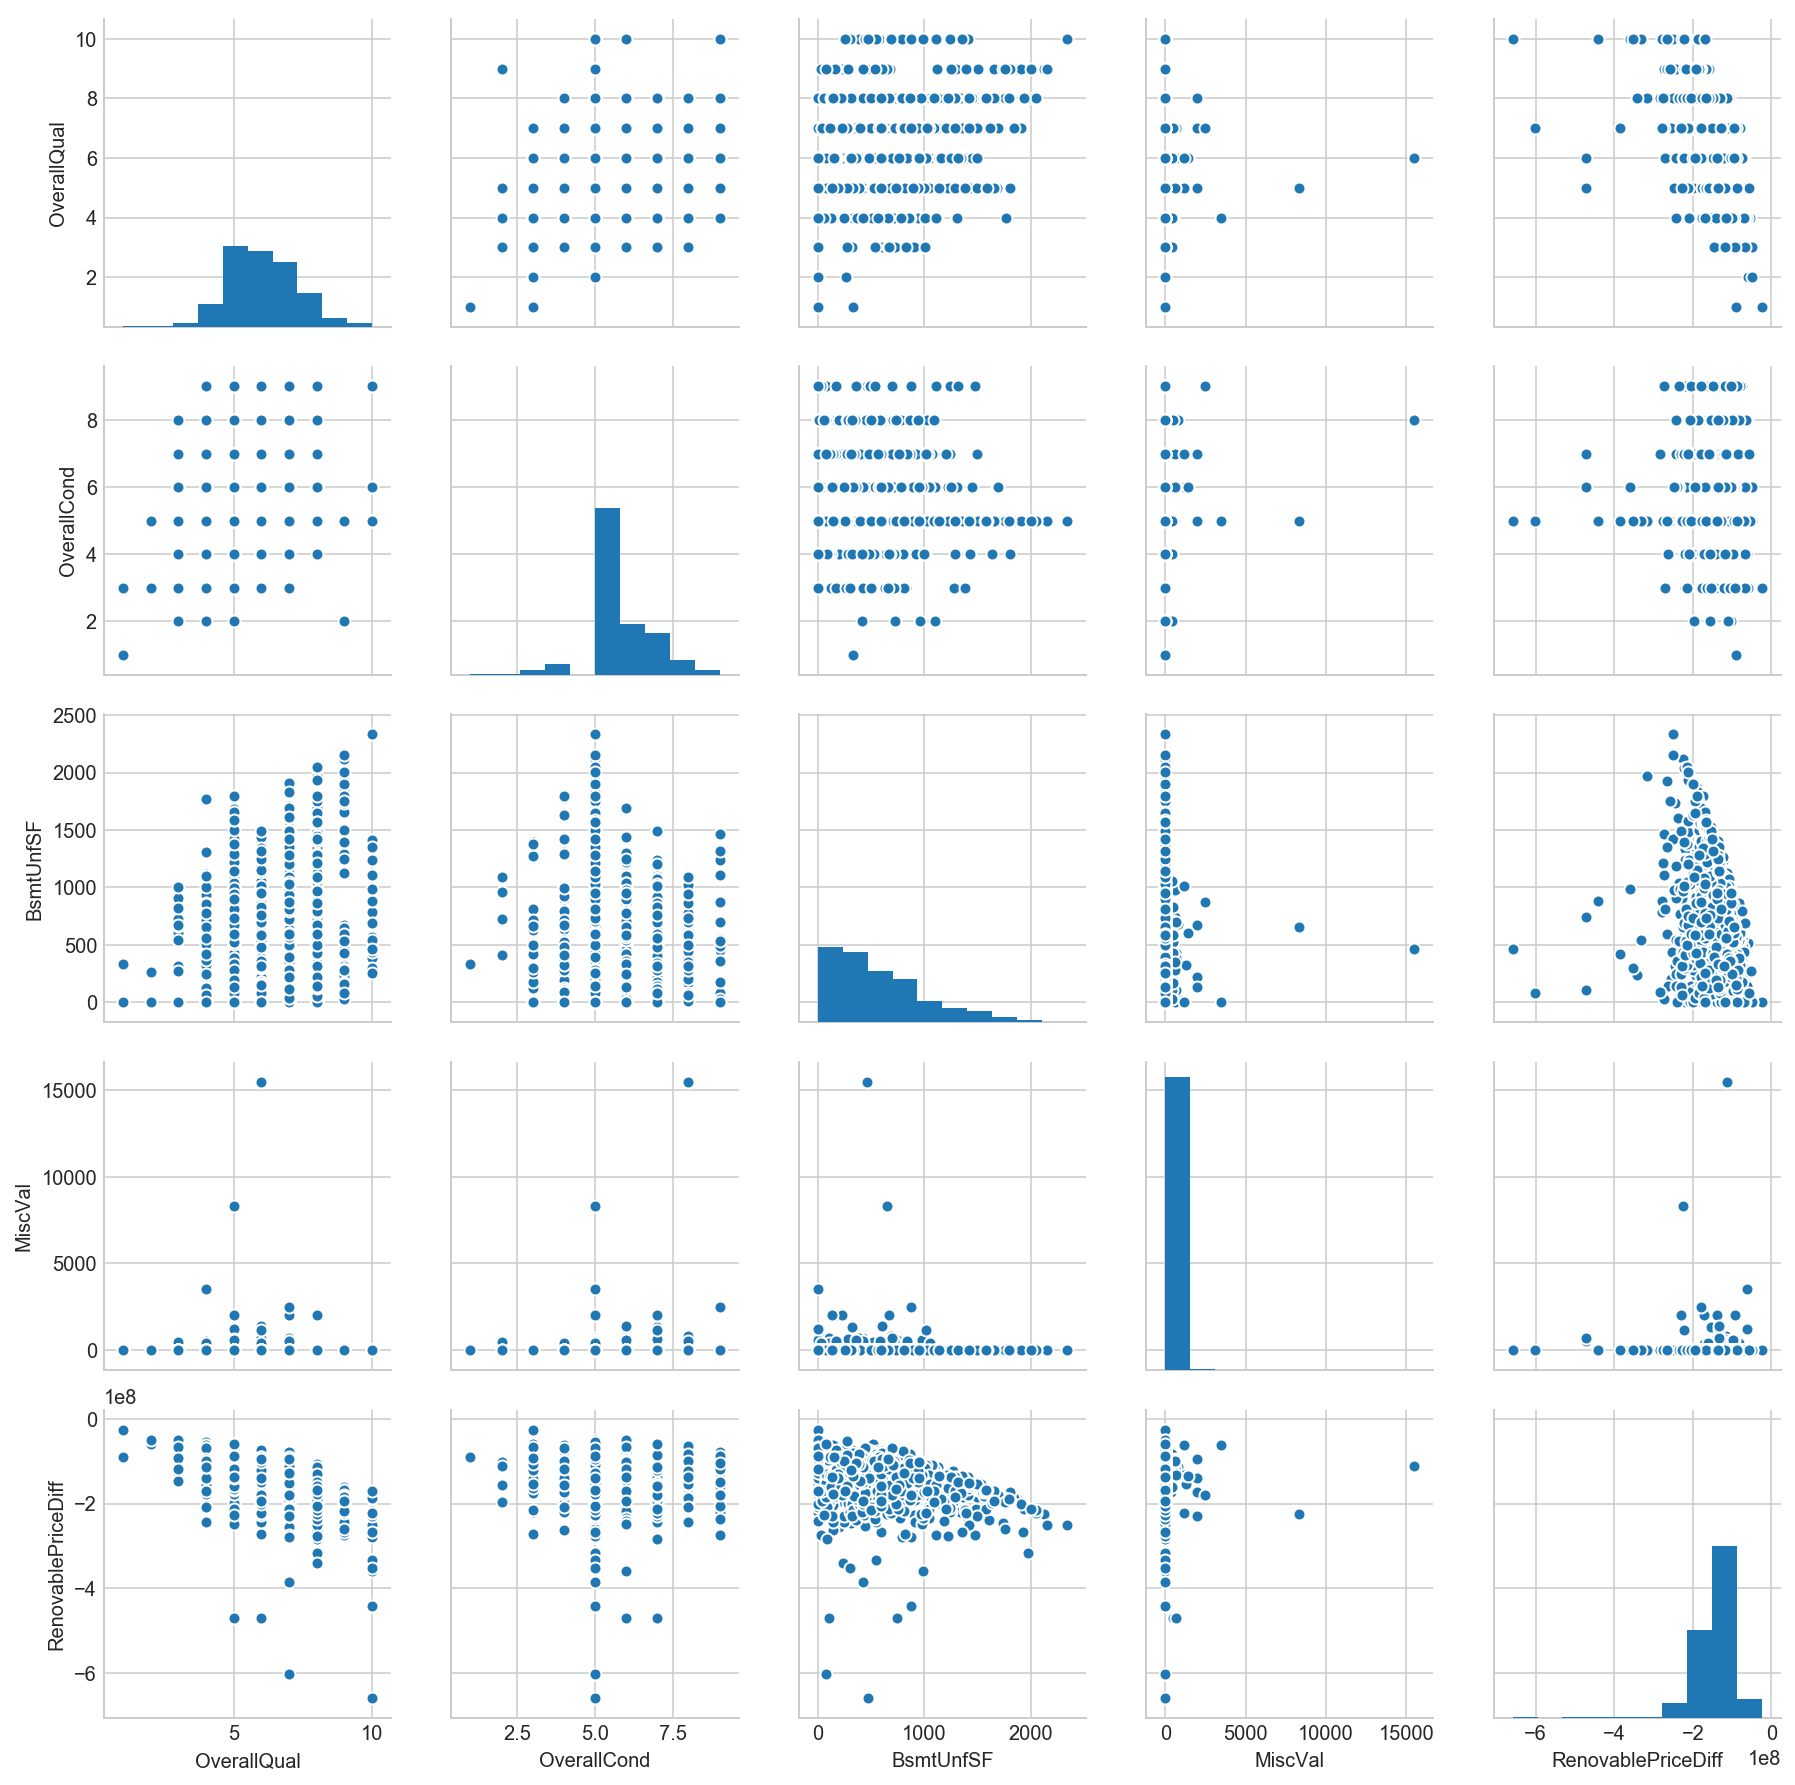

In [45]:
r_columns_to_analyze = ['OverallQual', 'OverallCond', 'BsmtUnfSF', 'MiscVal', 'RenovablePriceDiff']
plt.figure(figsize=(15, 9))
sns.pairplot(df_residental_house[r_columns_to_analyze])
plt.show()

In [46]:
# Provide scores for renovable features that are presented as ordinals
# Only features that are can be quantified such as quality and condition and features where there is a
# correlation between price difference and the feature will be given a score.
dict_utilities_score = {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0}
df_residental_house['Utilities_score'] = df_residental_house['Utilities'].map(lambda v: dict_utilities_score[v])

dict_quality_score = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
df_residental_house['ExterQual_score'] = df_residental_house['ExterQual'].map(lambda v: dict_quality_score[v])
df_residental_house['ExterCond_score'] = df_residental_house['ExterCond'].map(lambda v: dict_quality_score[v])

dict_opt_quality_score = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0, 'NA': 2}
df_residental_house['BsmtQual_score'] = df_residental_house['BsmtQual'].map(lambda v: dict_opt_quality_score[v])
df_residental_house['BsmtCond_score'] = df_residental_house['BsmtCond'].map(lambda v: dict_opt_quality_score[v])

dict_bsmt_rating_score = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':2, 'LwQ':1, 'Unf':0, 'NA':2}
df_residental_house['BsmtFinType1_score'] = df_residental_house['BsmtFinType1'].map(lambda v: dict_bsmt_rating_score[v])
#df_residental_house['BsmtFinType2_score'] = df_residental_house['BsmtFinType2'].map(lambda v: dict_bsmt_rating_score[v])

df_residental_house['HeatingQC_score'] = df_residental_house['HeatingQC'].map(lambda v: dict_quality_score[v])

df_residental_house['CentralAir_score'] = df_residental_house['CentralAir'].map(lambda v: 1 if v == 'Y' else '0')

dict_electrical_score = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0, 'Mix':2}
df_residental_house['Electrical_score'] = df_residental_house['Electrical'].map(lambda v: dict_electrical_score[v])

df_residental_house['KitchenQual_score'] = df_residental_house['KitchenQual'].map(lambda v: dict_quality_score[v])

dict_func_score = {'Typ':5, 'Min1':4, 'Min2':4, 'Mod':3, 'Maj1':2, 'Maj2':2, 'Sev':1, 'Sal':0}
df_residental_house['Functional_score'] = df_residental_house['Functional'].map(lambda v: dict_func_score[v])

df_residental_house['FireplaceQu_score'] = df_residental_house['FireplaceQu'].map(lambda v: dict_opt_quality_score[v])

dict_garageFinish_score = {'Fin':2, 'RFn':1, 'Unf':0, 'NA':1}
df_residental_house['GarageFinish_score'] = df_residental_house['GarageFinish'].map(lambda v: dict_garageFinish_score[v])

df_residental_house['GarageQual_score'] = df_residental_house['GarageQual'].map(lambda v: dict_opt_quality_score[v])
df_residental_house['GarageCond_score'] = df_residental_house['GarageCond'].map(lambda v: dict_opt_quality_score[v])

dict_pavedDrive_score = {'Y': 2, 'P': 1, 'N': 0}
df_residental_house['PavedDrive_score'] = df_residental_house['PavedDrive'].map(lambda v: dict_pavedDrive_score[v])

df_residental_house['PoolQC_score'] = df_residental_house['PoolQC'].map(lambda v: dict_opt_quality_score[v])

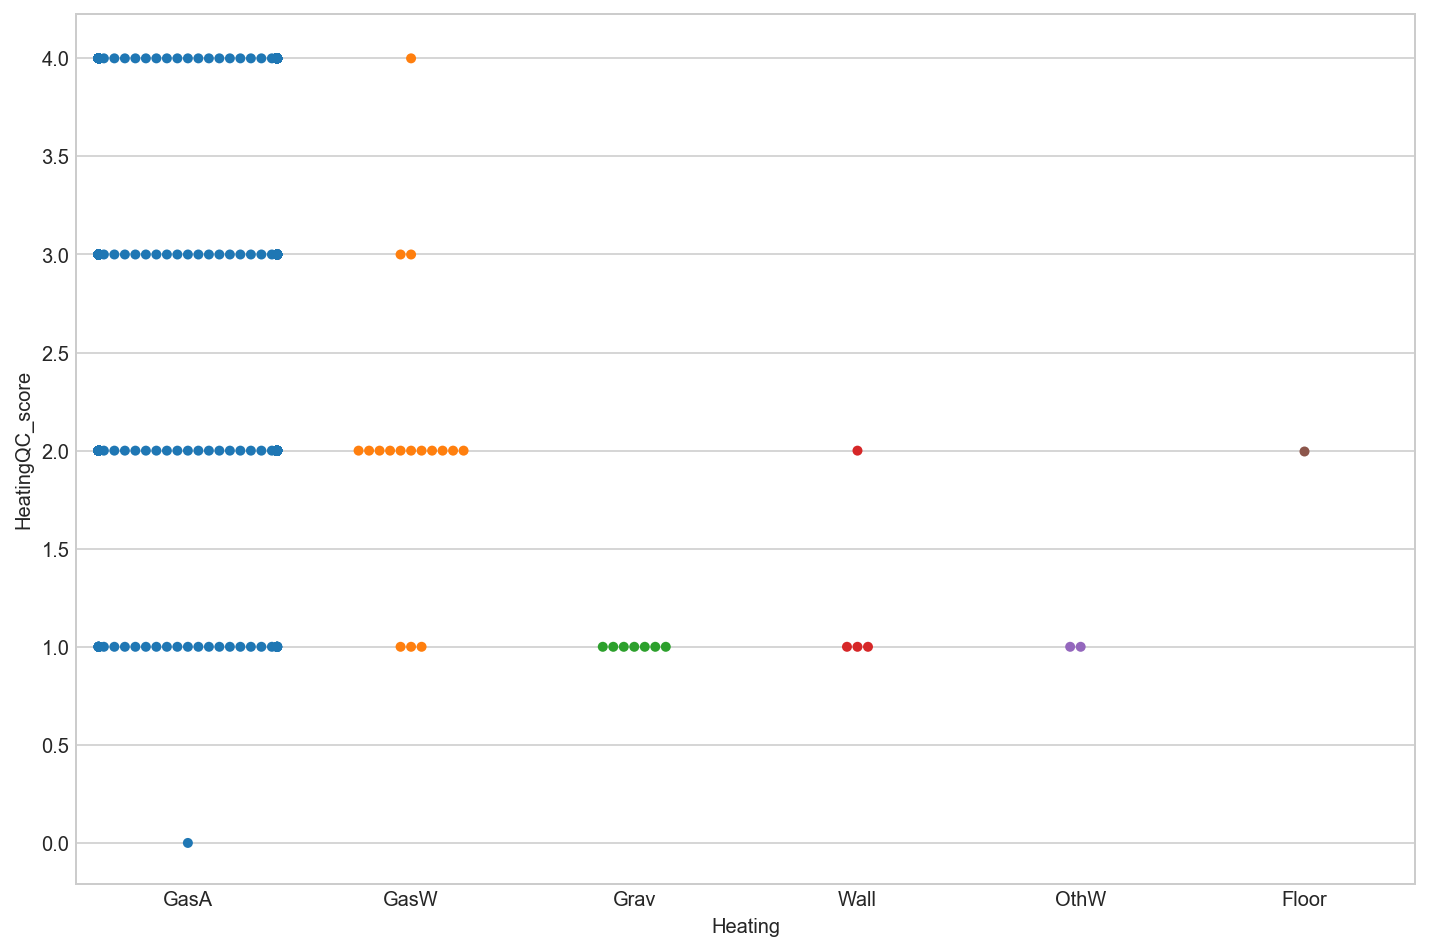

In [47]:
# Determine if there is a correlation between heating type and heating QC.
plt.figure(figsize=(12, 8))
sns.swarmplot(x='Heating', y='HeatingQC_score', data=df_residental_house)
plt.show()

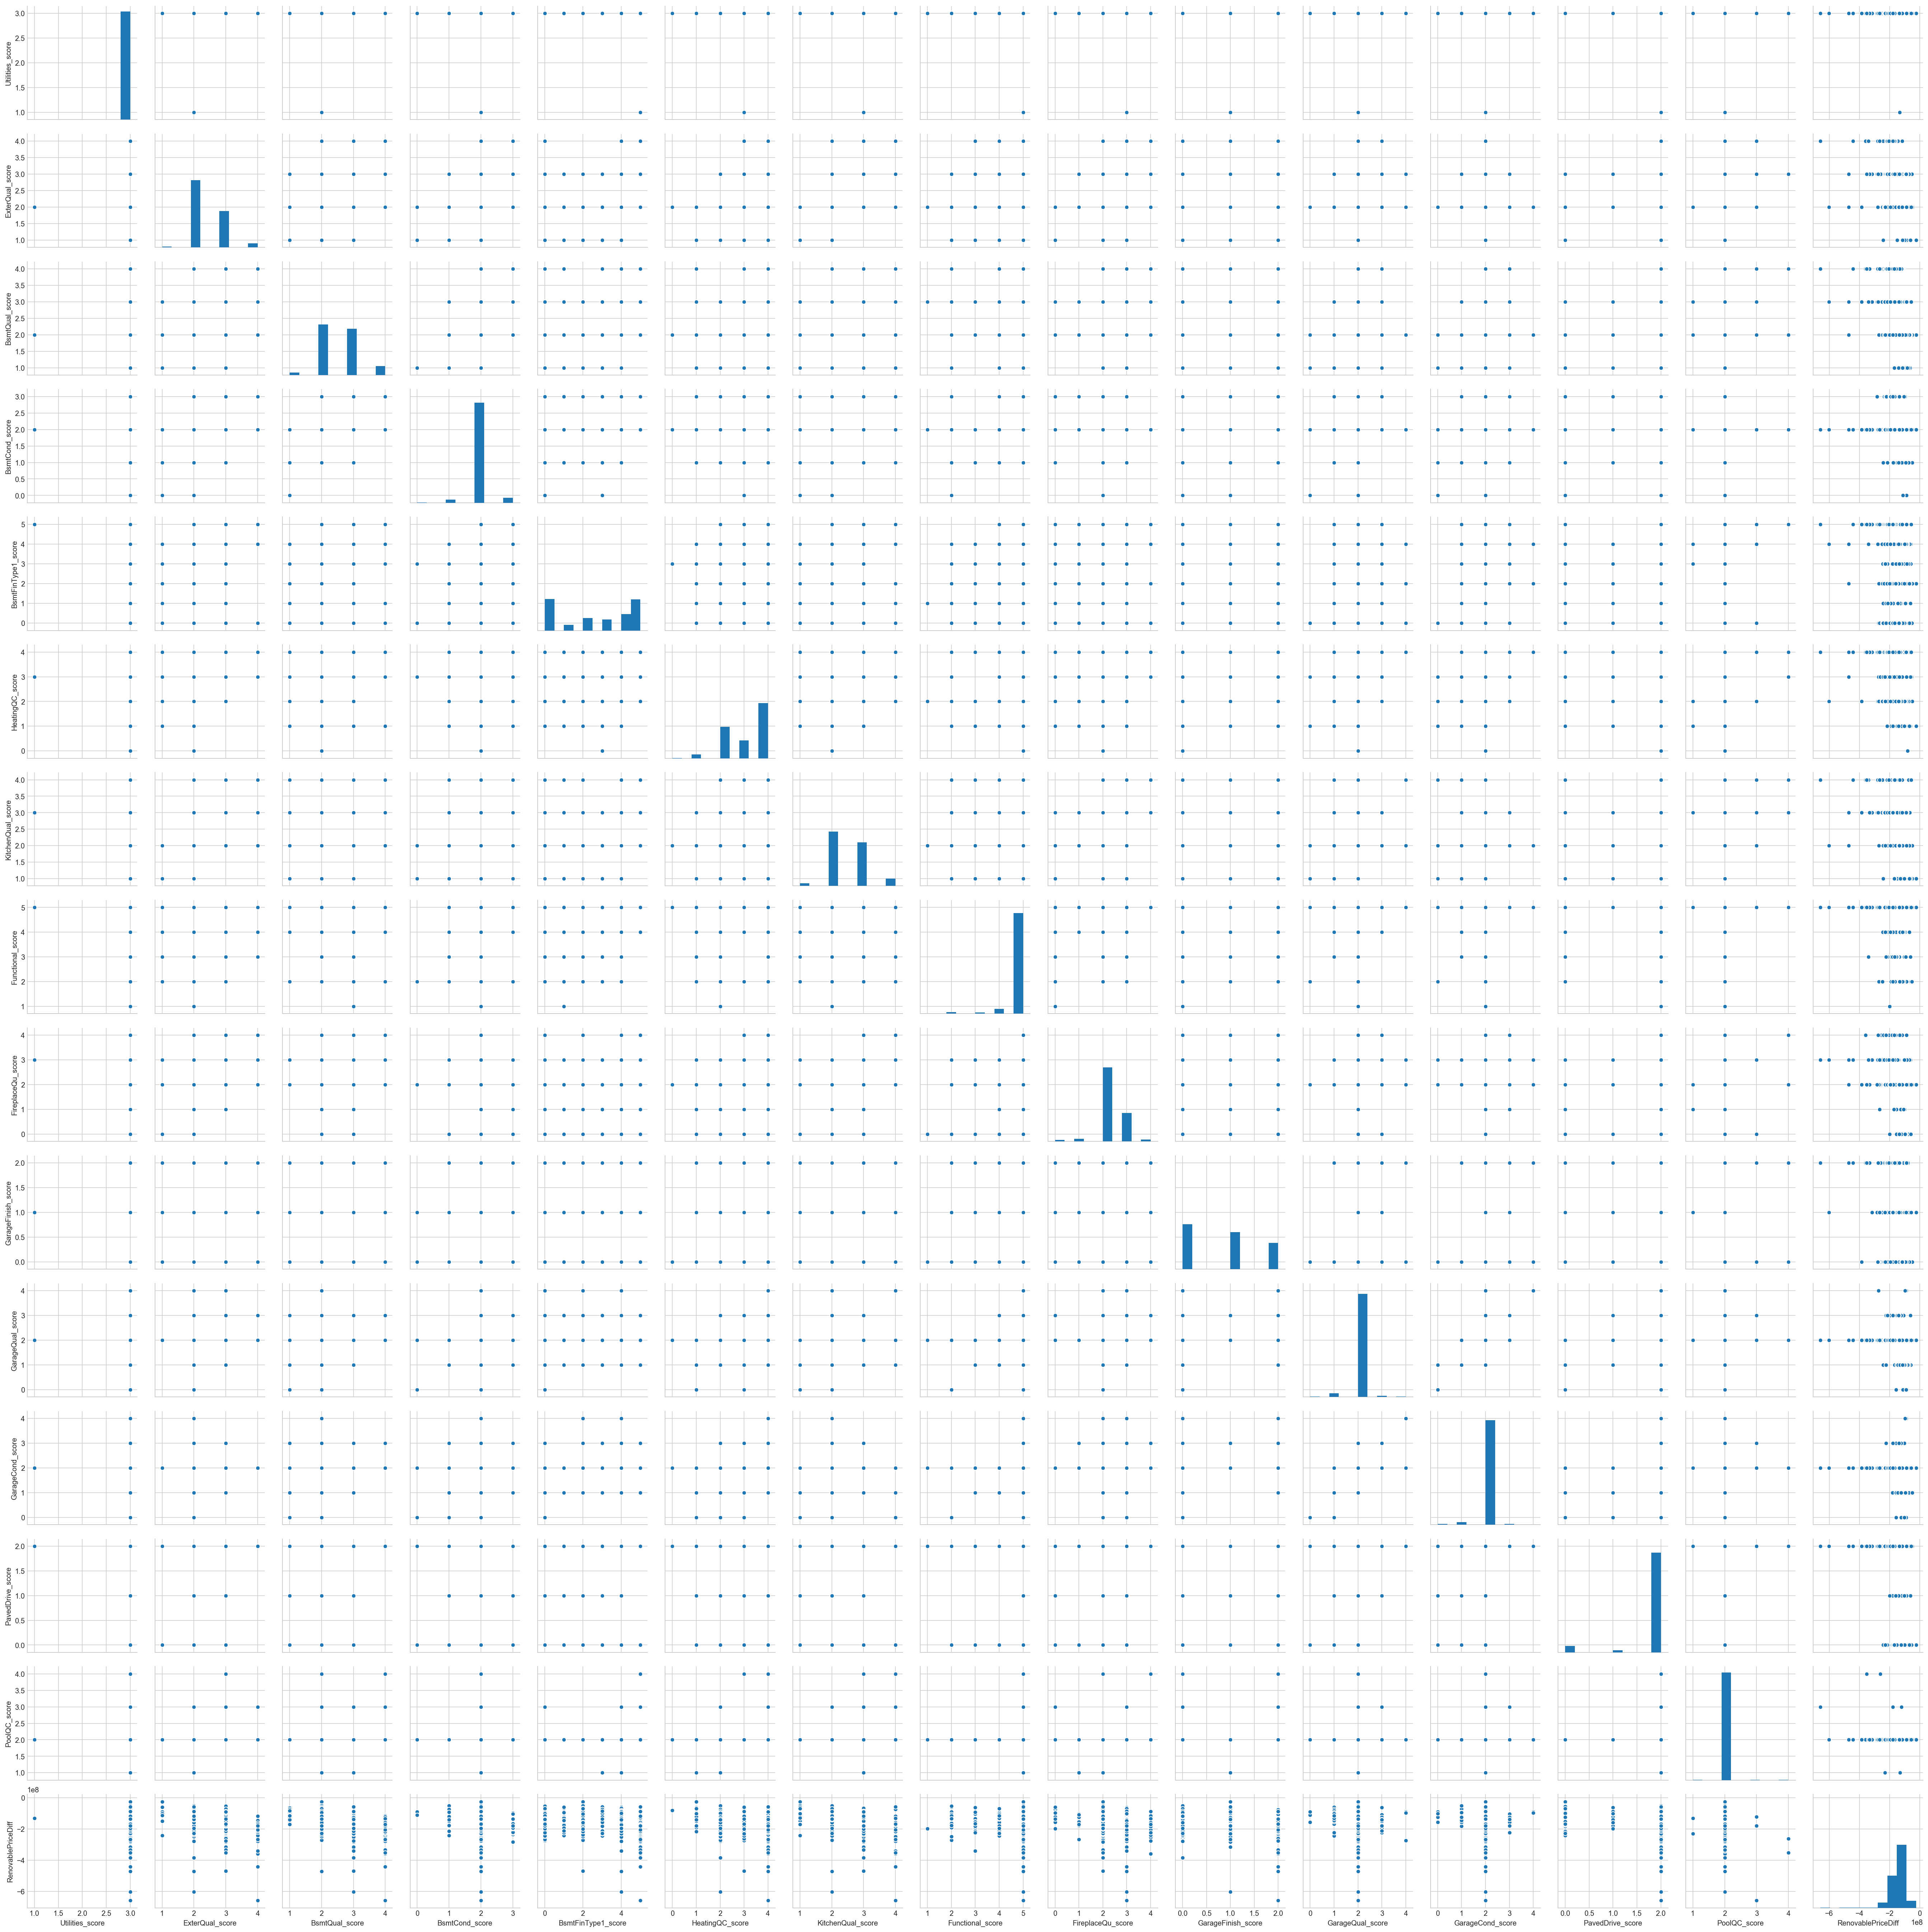

In [48]:
# Understand correlation between features using pairplot.
r2_columns_to_analyze = ['Utilities_score', 'ExterQual_score', 
             'BsmtQual_score', 'BsmtCond_score', 'BsmtFinType1_score', 'HeatingQC_score', 
             'KitchenQual_score', 'Functional_score', 
             'FireplaceQu_score', 'GarageFinish_score', 'GarageQual_score', 'GarageCond_score', 
             'PavedDrive_score', 'PoolQC_score', 'RenovablePriceDiff']
plt.figure(figsize=(15, 9))
sns.pairplot(df_residental_house[r2_columns_to_analyze])
plt.show()

In [49]:
# Consider adding factors (scores) that affect the price diff
column_X3 = ['OverallQual', 'OverallCond', 'ExterQual_score', 
             'BsmtQual_score', 'BsmtFinType1_score', 'BsmtUnfSF', 
             'HeatingQC_score', 'CentralAir_score', 'KitchenQual_score', 'Functional_score', 
             'FireplaceQu_score', 'GarageFinish_score', 'GarageQual_score', 
             'PavedDrive_score', 'PoolQC_score', 'MiscVal']

In [50]:
# Split data set into training and test set.
y3_train = df_residental_house.loc[df_residental_house['YrSold'] < 2010, 'RenovablePriceDiff'].copy()
y3_test = df_residental_house.loc[df_residental_house['YrSold'] == 2010, 'RenovablePriceDiff'].copy()
X3_train = df_residental_house.loc[df_residental_house['YrSold'] < 2010, column_X3].copy()
X3_test = df_residental_house.loc[df_residental_house['YrSold'] == 2010, column_X3].copy()

In [51]:
# Do standard scaling
X3s_train = ss.fit_transform(X3_train)
X3s_test = ss.transform(X3_test)

In [52]:
# Train using regression with ElasticNet with 6-fold (about 200 per fold) cross-validation and test
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet3 = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=6)
optimal_enet3.fit(X3s_train, y3_train)

print (optimal_enet3.alpha_)
print (optimal_enet3.l1_ratio_)

print ("Score with training set: {}".format(optimal_enet3.score(X3s_train, y3_train)))
print ("Score with test set: {}".format(optimal_enet3.score(X3s_test, y3_test)))

1009653.4460892507
1.0
Score with training set: 0.411933035482
Score with test set: 0.473248265186


In [53]:
optimal_enet3.coef_

array([-20914713.93340682,     97114.93922352,        -0.        ,
        -1203839.31961113,  -5765808.43423698,  -7990868.27762275,
         1235763.33266832,        -0.        ,   -887574.22217266,
         4414367.21720684,  -3252362.60687727,  -2684534.63785807,
              -0.        ,    -24641.83489324,  -5607434.91537524,
         -545352.06322975])

In [54]:
# Determine the renovateable features that can affect price residue.
[(feature, coef) for (feature, coef) in zip(column_X3, optimal_enet3.coef_.tolist()) if coef != 0]

[('OverallQual', -20914713.933406822),
 ('OverallCond', 97114.93922351541),
 ('BsmtQual_score', -1203839.3196111345),
 ('BsmtFinType1_score', -5765808.43423698),
 ('BsmtUnfSF', -7990868.277622748),
 ('HeatingQC_score', 1235763.332668316),
 ('KitchenQual_score', -887574.2221726553),
 ('Functional_score', 4414367.217206844),
 ('FireplaceQu_score', -3252362.606877267),
 ('GarageFinish_score', -2684534.6378580695),
 ('PavedDrive_score', -24641.834893243235),
 ('PoolQC_score', -5607434.915375244),
 ('MiscVal', -545352.0632297457)]

In [55]:
# Determine the renovateable features that can improve price.
[(feature, coef) for (feature, coef) in zip(column_X3, optimal_enet3.coef_.tolist()) if coef > 0]

[('OverallCond', 97114.93922351541),
 ('HeatingQC_score', 1235763.332668316),
 ('Functional_score', 4414367.217206844)]

***
From the coefficients in model two, it is possible that any improvements in the following features will reduce the Sale Price of the house:
1. Overall Quality
2. Basement Quality
3. Basement Finish Type
4. Kitchen Quality
5. Fireplace Quality
6. Garage Finish
7. Pool Quality
8. Value of miscellaneous features

However the increase in the following features can increase the sale price of the house:
1. Overall Condition
2. Heating Quality
3. Functionality of the house

The second model indicates that not all renovations can actually increase the sale price of the house. This can prevent any unnecessary spending on renovations that can reduce the profits from the sale.

To maximize the company profits, the company can use model one to determine where to find the cheapest property to buy and model two to determine how much renovations to carry out and the type of renovations to carry out to increase the sale price.

However, the score of model two is less than 0.5, making the model less reliable in determining the price improvement due to renovation. In addition it does not depend on the fixed features of the property and the quality and condition scores are subjective. Hence it cannot be used to determine which property to buy and fix up.
***

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [56]:
df_residental_house['IsAbnormalSale'] = df_residental_house['SaleCondition'].map(lambda v: 1 if v == 'Abnorml' else 0)

In [57]:
# Determine the number of abnormal sales to the number of normal sales.
len(df_residental_house[df_residental_house['IsAbnormalSale'] == True]), len(df_residental_house[df_residental_house['IsAbnormalSale'] == False])

(96, 1354)

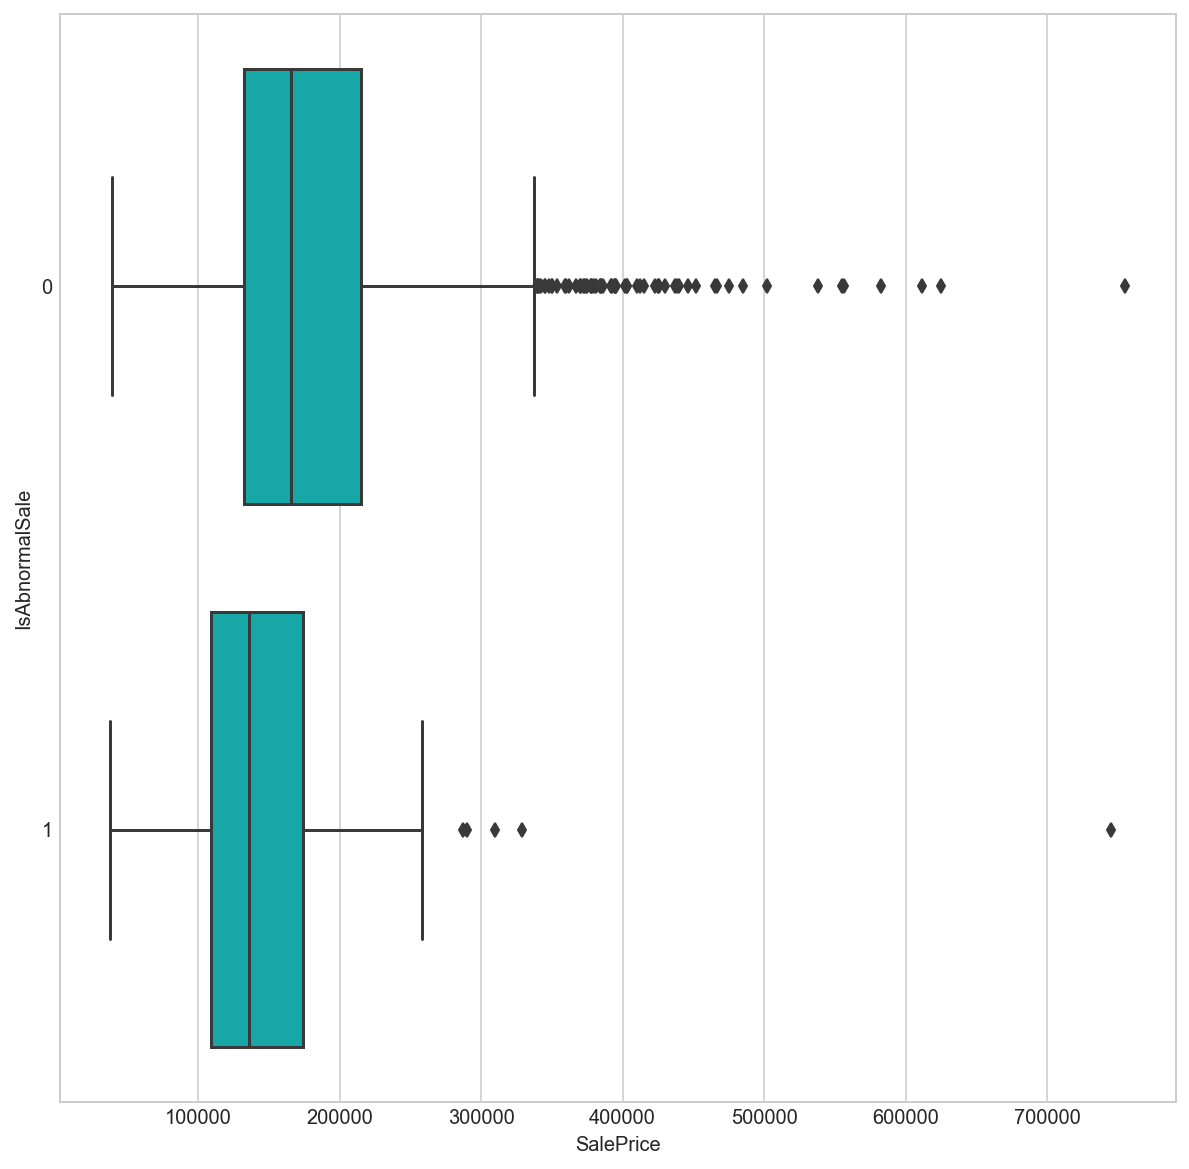

In [58]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='SalePrice', y='IsAbnormalSale', data=df_residental_house, orient='h', color='c')
plt.show()

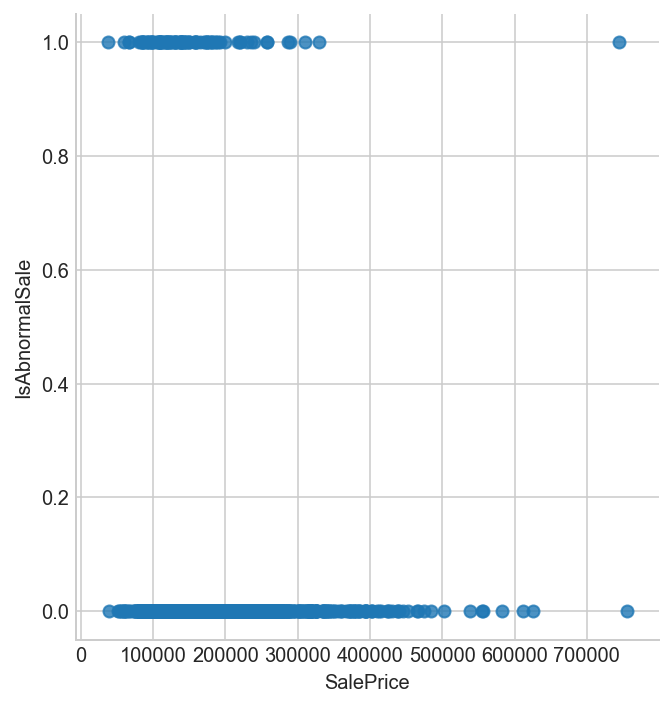

In [59]:
plt.figure(figsize=(15, 9))
sns.lmplot(x='SalePrice', y='IsAbnormalSale', data=df_residental_house, fit_reg=False)
plt.show()

In [60]:
# Based on the above plot, the SalePrice for abnormal sales are usually lower than that of other sales.
# We will need to find other features that can shift the points at 1 and 0 further 
# and reduce overlap so that a more accurate logistic regression can be built.

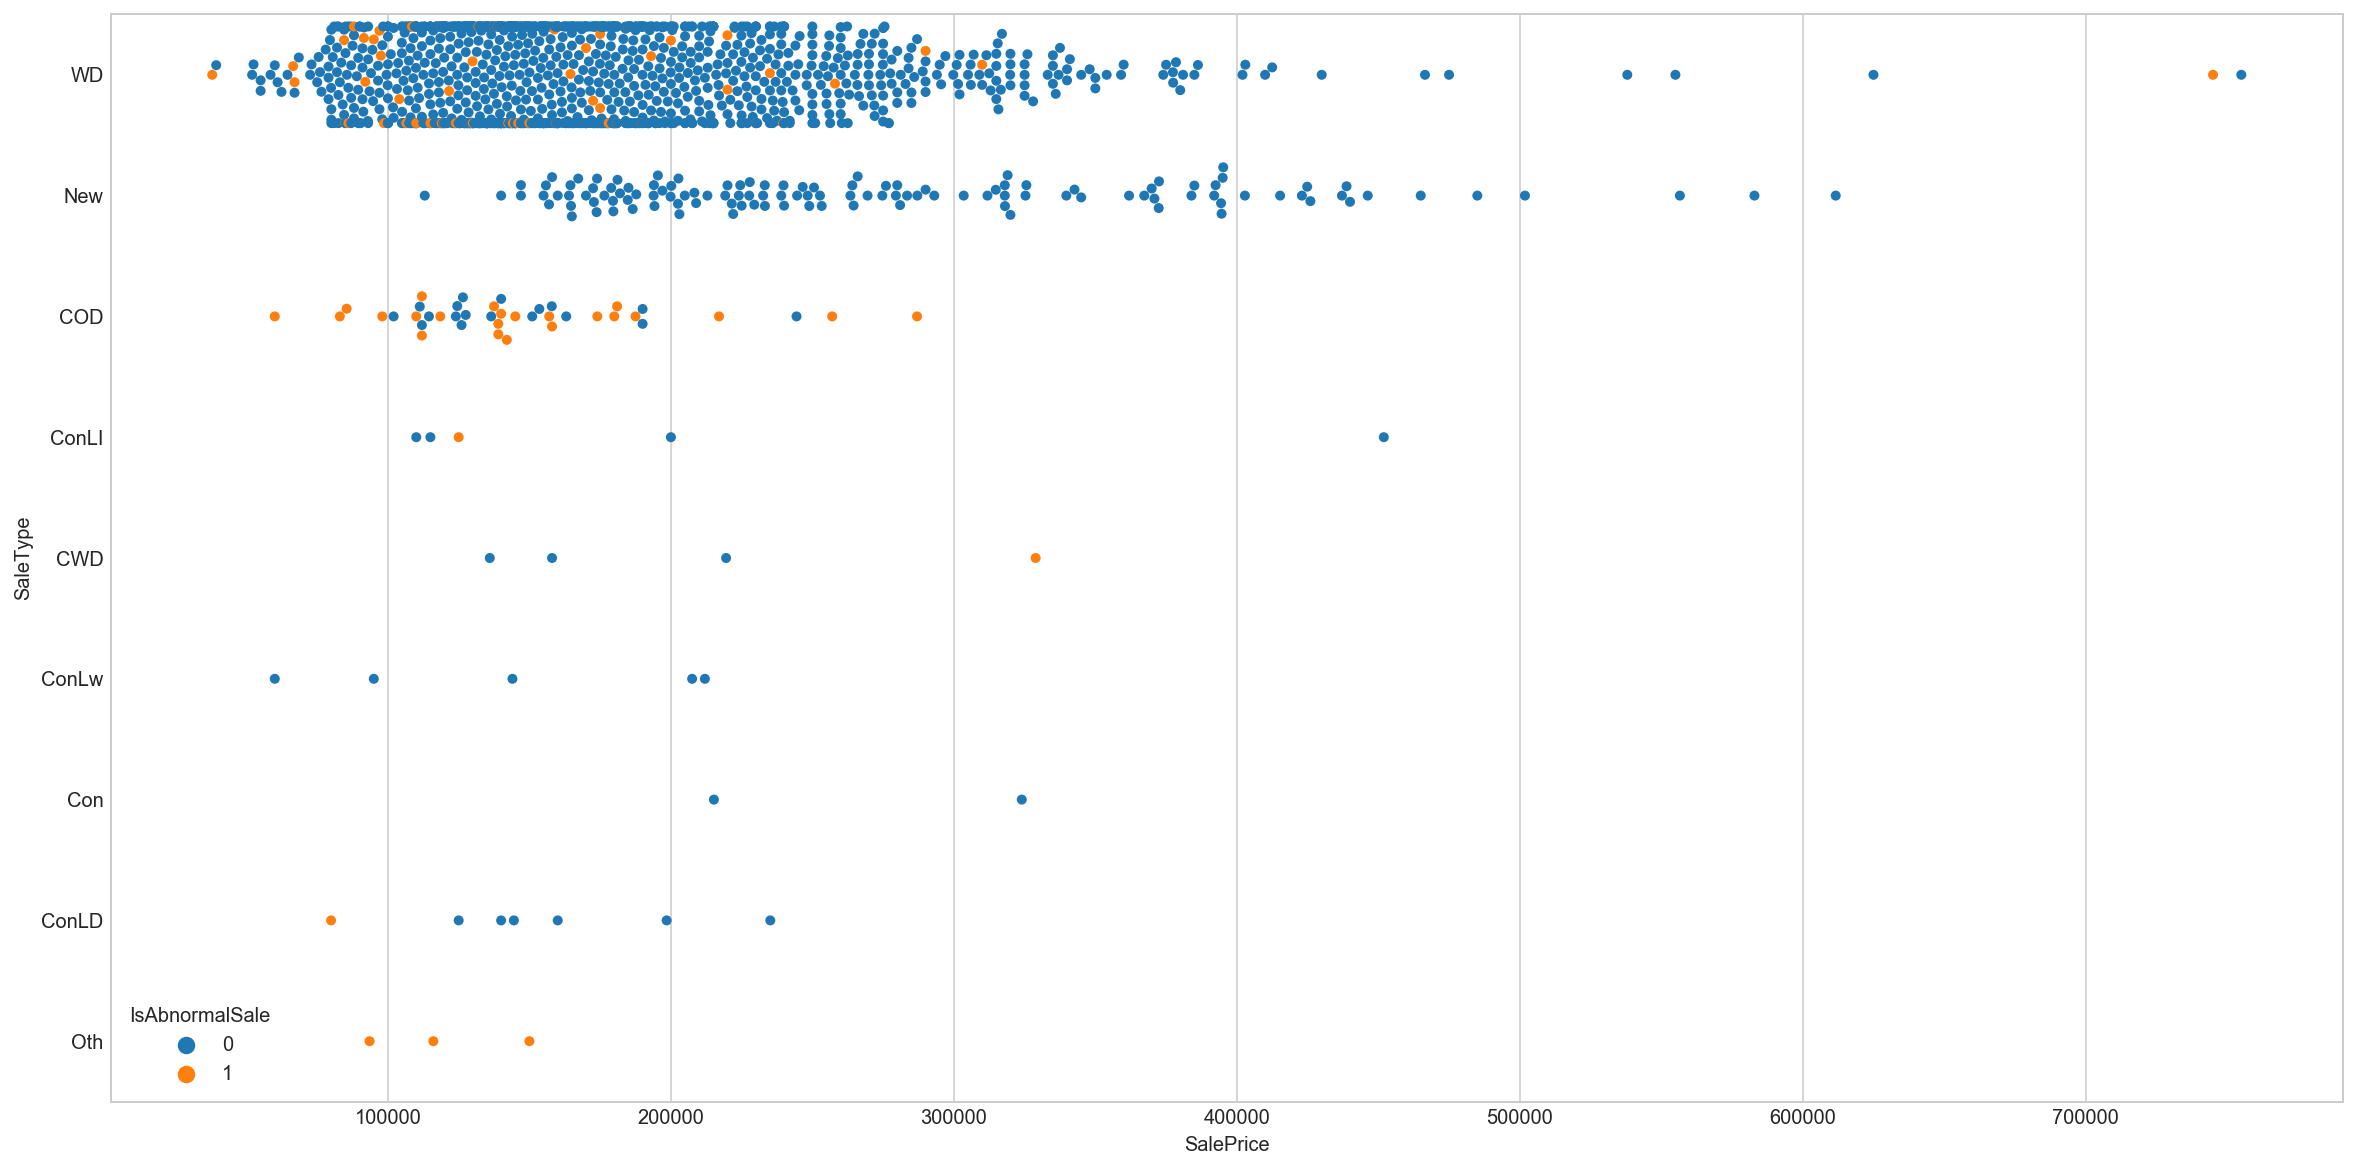

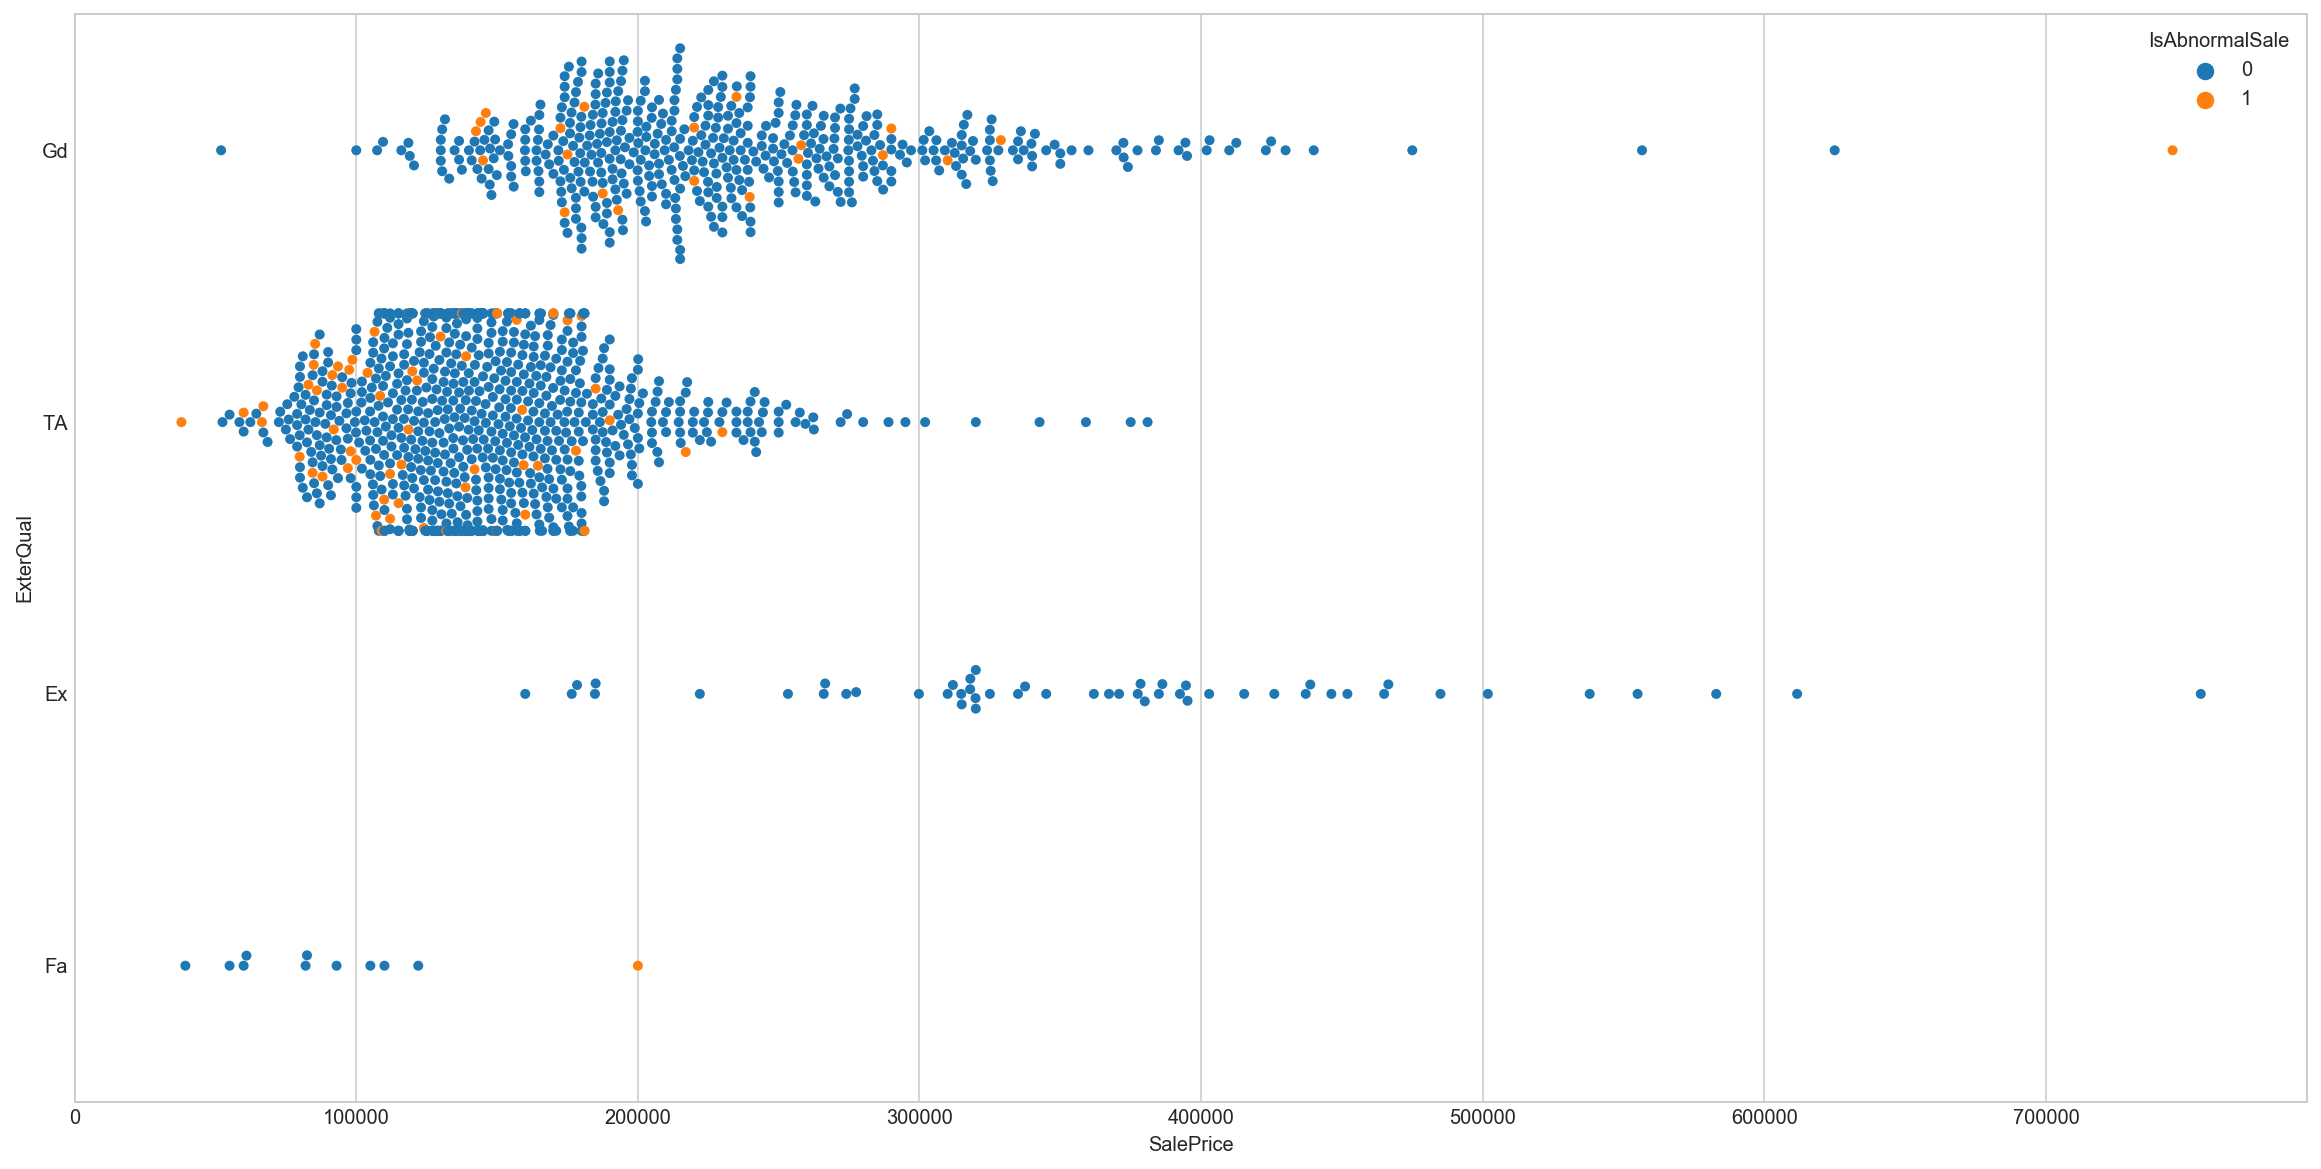

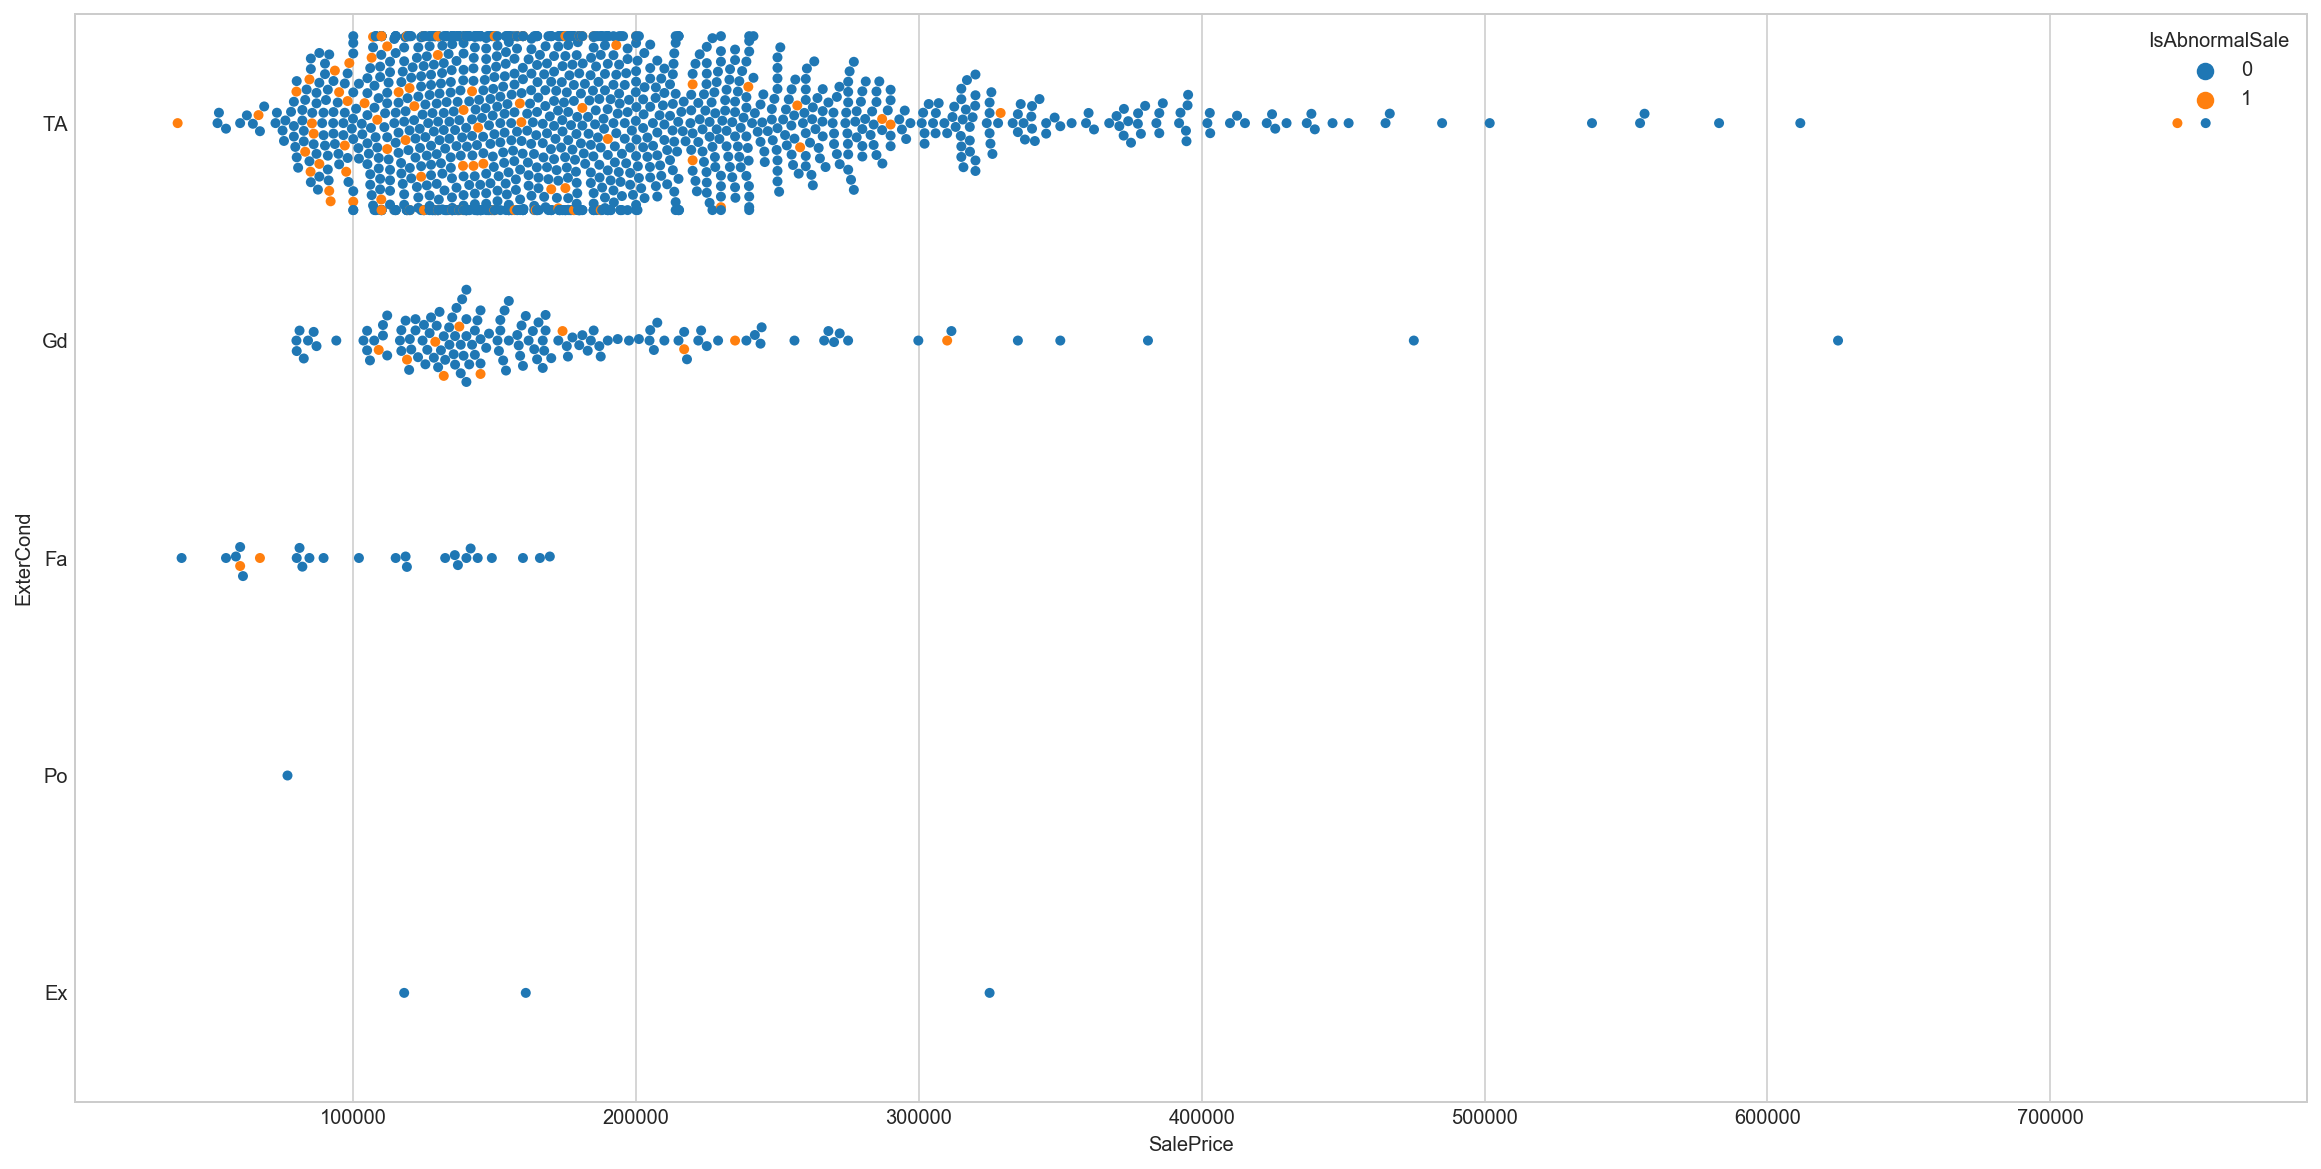

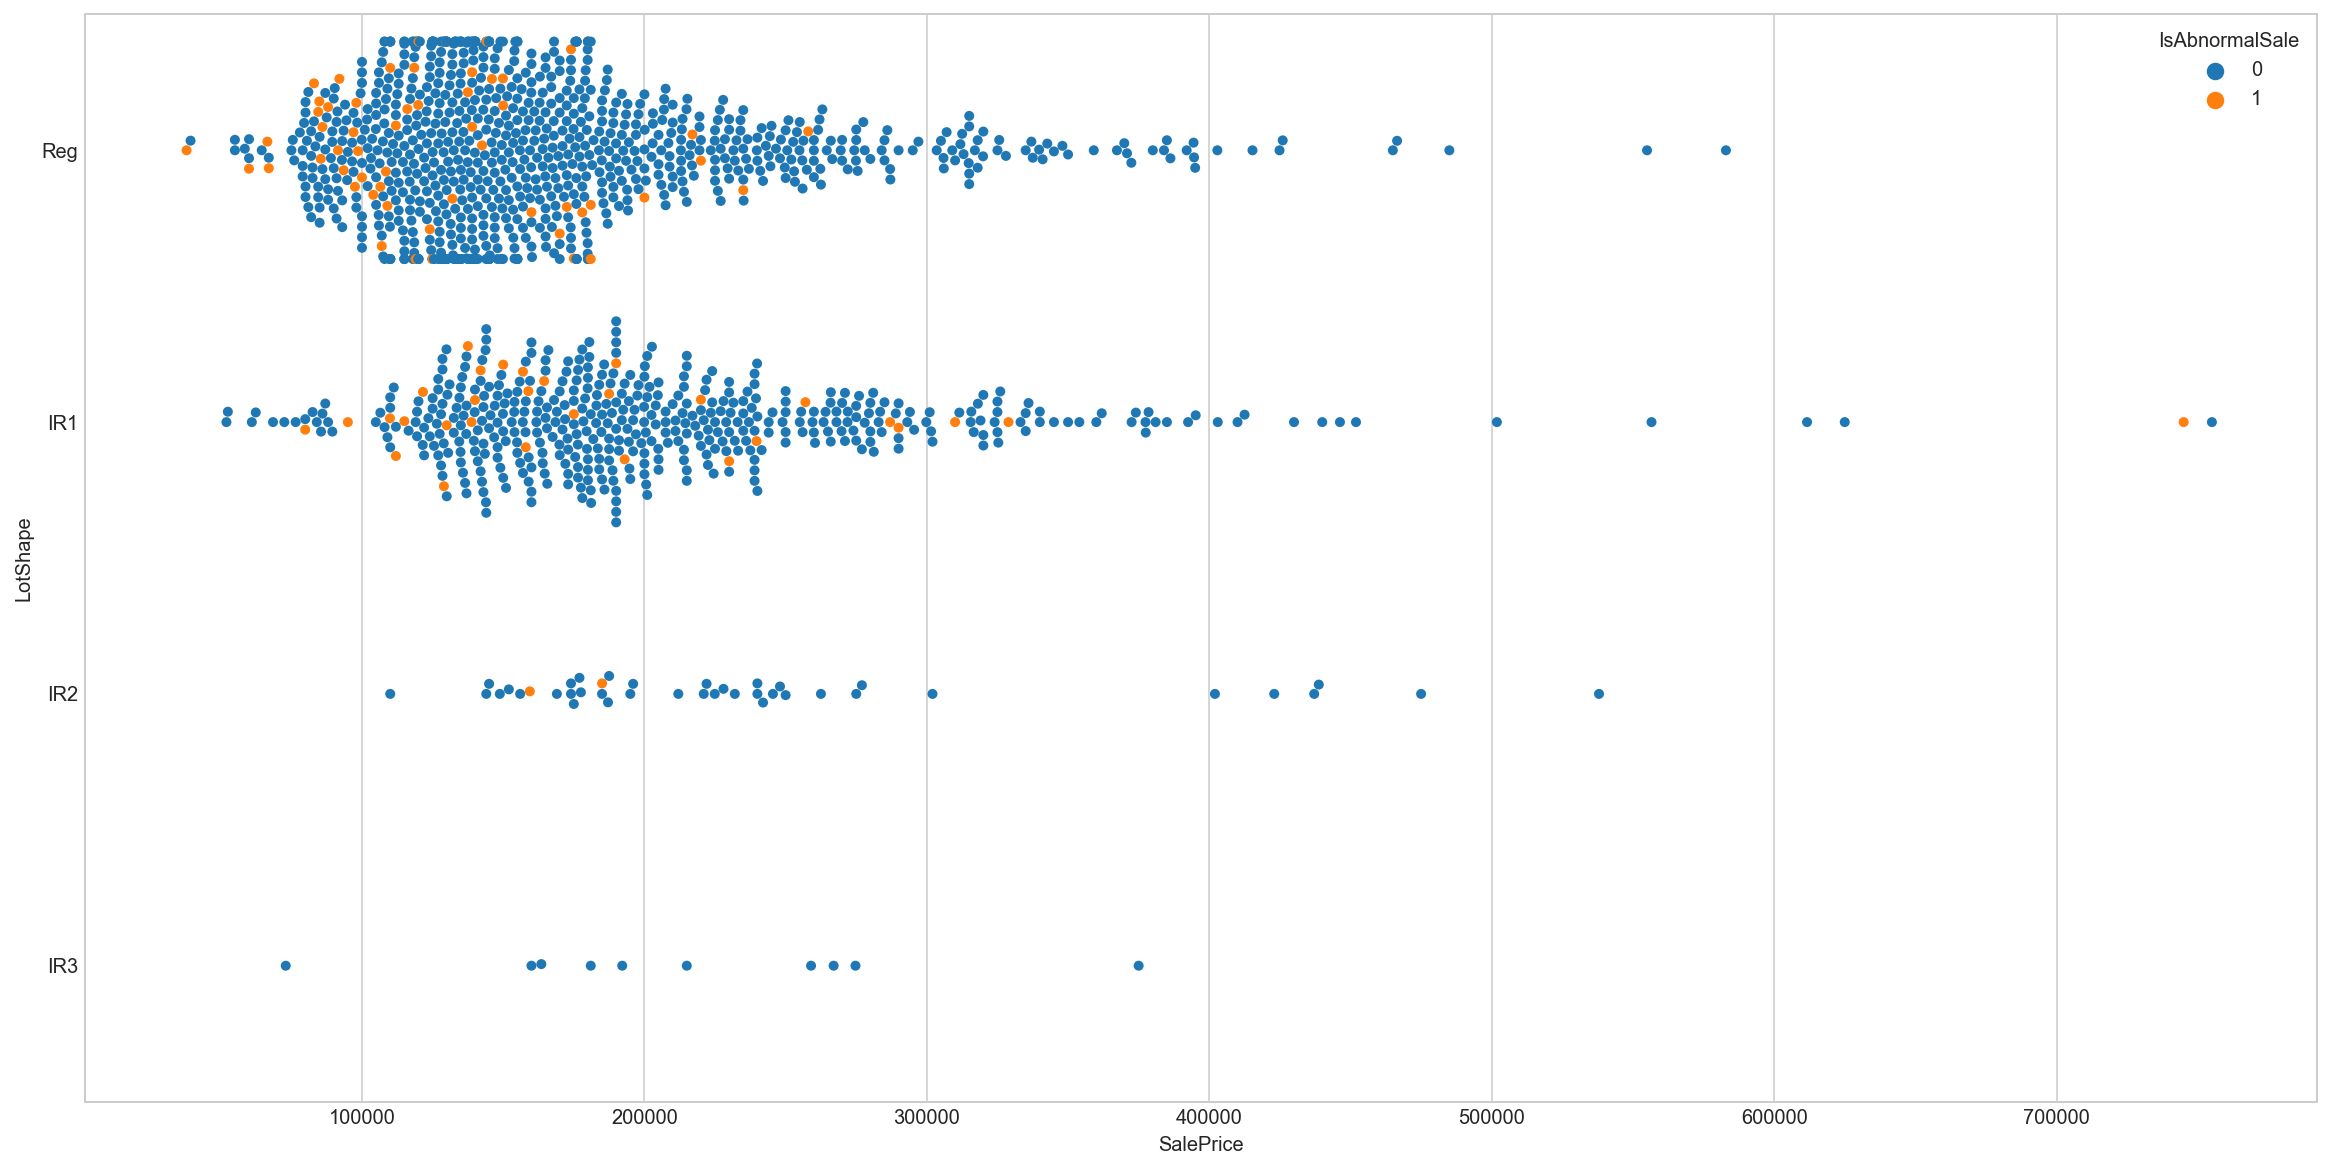

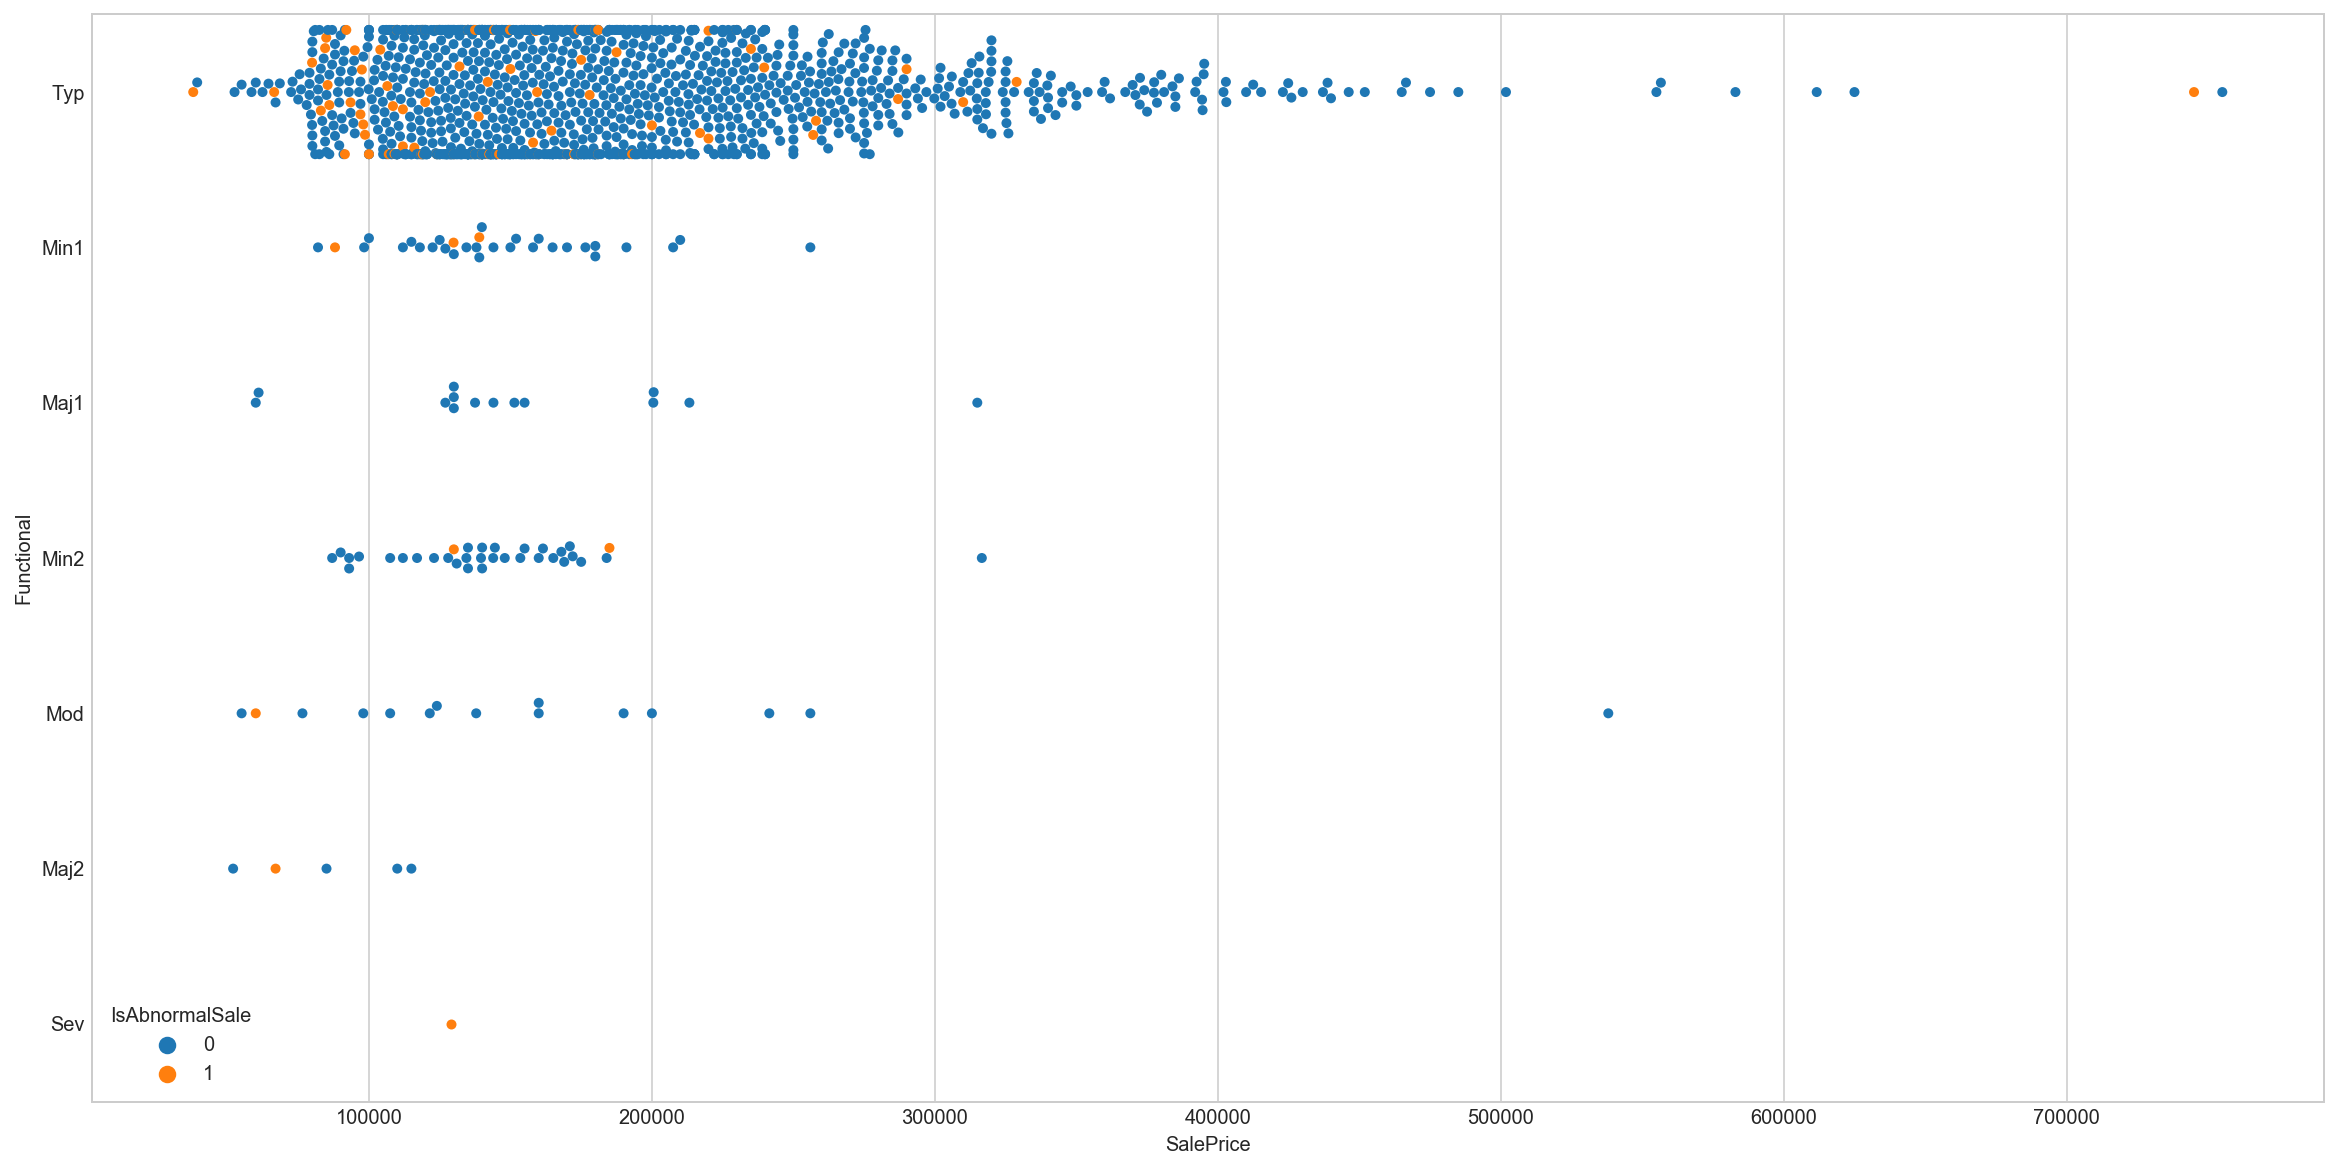

In [61]:
features_to_analyze = ['SaleType', 'ExterQual', 'ExterCond', 'LotShape', 'Functional']
for column in features_to_analyze:
    plt.figure(figsize=(20, 10))
    sns.swarmplot(x='SalePrice', y=column, hue='IsAbnormalSale', data=df_residental_house)
    plt.show()

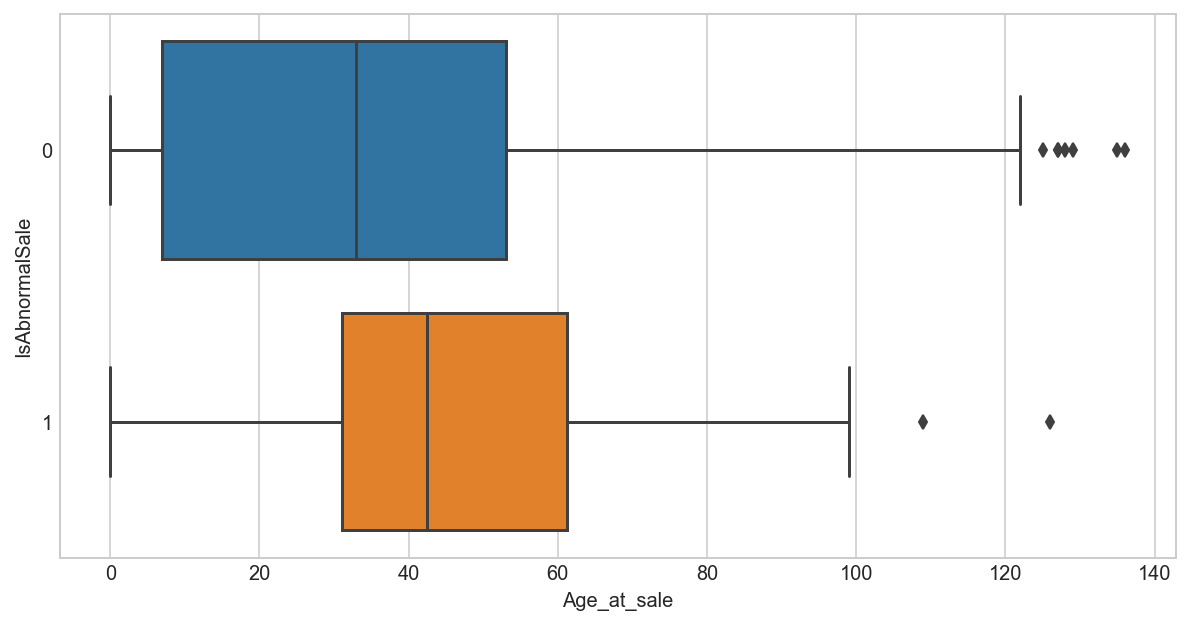

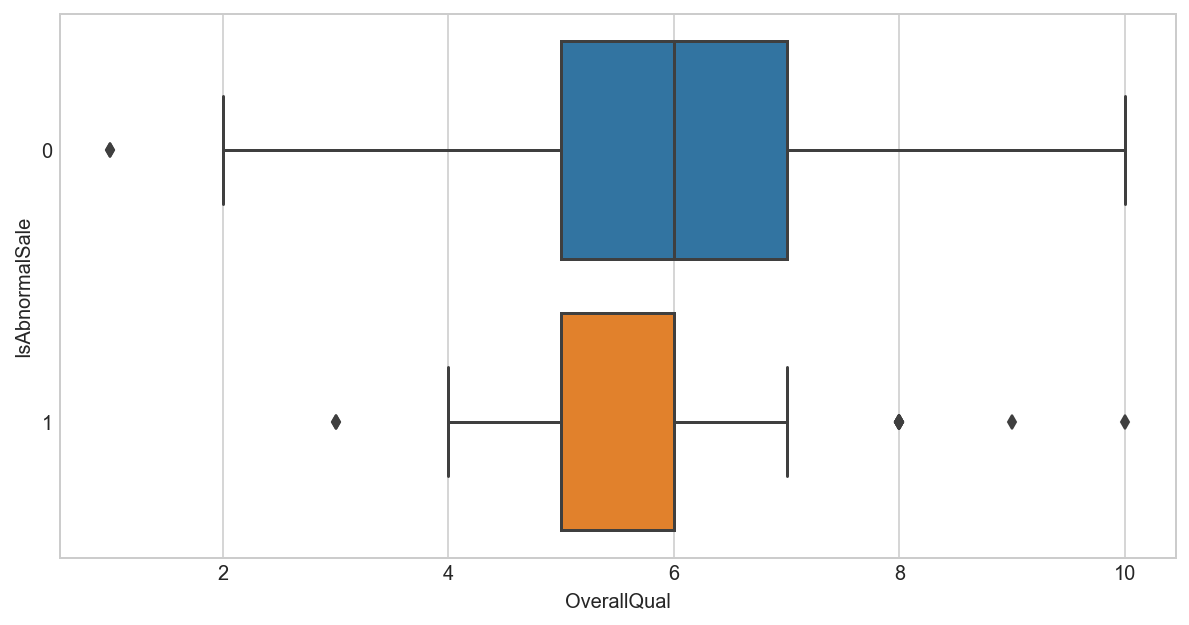

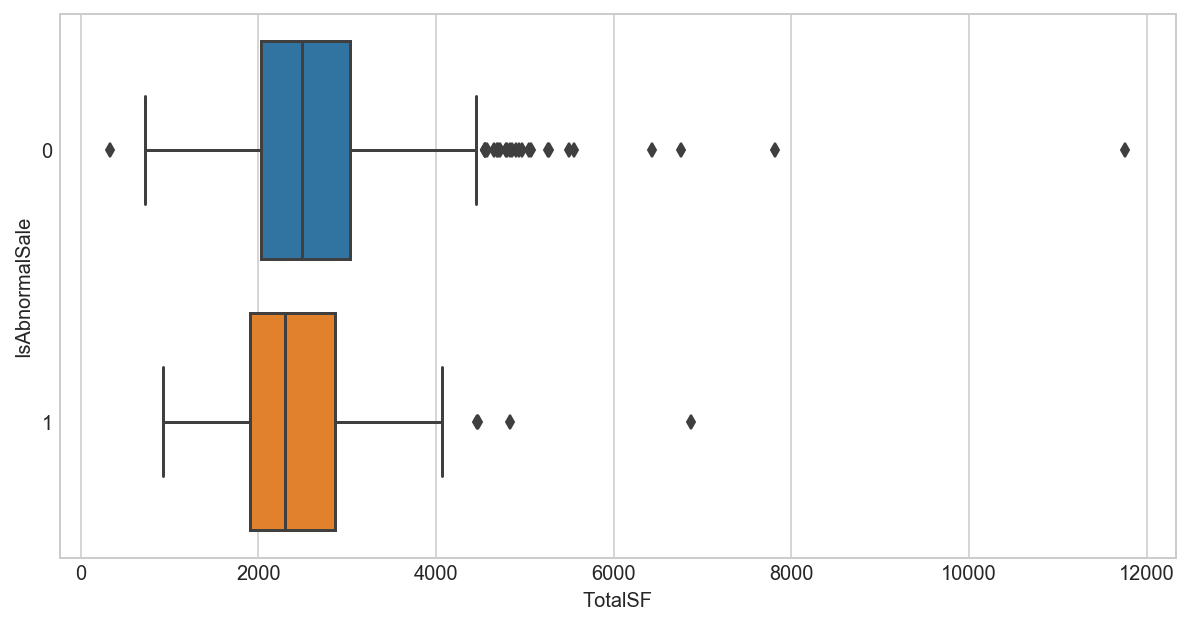

In [62]:
features_to_analyze_boxplot = ['Age_at_sale', 'OverallQual', 'TotalSF']
for feature in features_to_analyze_boxplot:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=feature, y='IsAbnormalSale', data=df_residental_house, orient='h')
    plt.show()

In [63]:
df_miscVal_abnormal = df_residental_house[['IsAbnormalSale', 'TotalSF']].copy()
df_miscVal_abnormal.groupby('IsAbnormalSale').apply(lambda v: v['TotalSF'].describe().T)

TotalSF,count,mean,std,min,25%,50%,75%,max
IsAbnormalSale,,,,,,,,
0,1354.0,2584.167651,819.457384,334.0,2036.0,2495.0,3034.75,11752.0
1,96.0,2477.531250,871.417997,930.0,1903.5,2298.5,2860.00,6872.0


In [64]:
df_saleType = pd.get_dummies(df_residental_house['SaleType'], prefix='SaleType')
df_saleType.drop(axis=1, columns=['SaleType_New', 'SaleType_ConLw', 'SaleType_Con'], inplace=True)
df_residental_house = pd.concat([df_residental_house, df_saleType], axis=1)
df_residental_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageCond_score,PavedDrive_score,PoolQC_score,IsAbnormalSale,SaleType_COD,SaleType_CWD,SaleType_ConLD,SaleType_ConLI,SaleType_Oth,SaleType_WD
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,2,2,2,0,0,0,0,0,0,1
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,2,2,2,0,0,0,0,0,0,1
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,2,2,2,0,0,0,0,0,0,1
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,2,2,2,1,0,0,0,0,0,1
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,2,2,2,0,0,0,0,0,0,1


In [65]:
# Consider all features that can determine if the sale is abnormal.
column_Xa = ['SalePrice', 'SaleType_COD', 'SaleType_CWD', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_Oth', 'SaleType_WD', 'Age_at_sale', 'OverallQual', 'ExterCond_score', 'TotalSF']

In [66]:
# Split data set into training and test set.
ya_train = df_residental_house.loc[df_residental_house['YrSold'] < 2010, 'IsAbnormalSale'].copy()
ya_test = df_residental_house.loc[df_residental_house['YrSold'] == 2010, 'IsAbnormalSale'].copy()
Xa_train = df_residental_house.loc[df_residental_house['YrSold'] < 2010, column_Xa].copy()
Xa_test = df_residental_house.loc[df_residental_house['YrSold'] == 2010, column_Xa].copy()

In [67]:
# Do standard scaling
Xas_train = ss.fit_transform(Xa_train)
Xas_test = ss.transform(Xa_test)

In [78]:
# Due to class imbalance, do down sampling using RandomUnderSampler on the majority class.
from imblearn.under_sampling import RandomUnderSampler

tlink = RandomUnderSampler(ratio='not minority', return_indices=False, random_state=200)
Xas_resampled, ya_resampled = tlink.fit_sample(Xas_train, ya_train)

In [69]:
# Get base accuracy
def base_accuracy(series):
    return np.mean(series) if np.mean(series) > 0.5 else 1 - np.mean(series)

In [80]:
base_accuracy(ya_resampled)

0.5

In [71]:
base_accuracy(ya_test)

0.9476744186046512

In [79]:
# We are predicting a binary result.
# Fit a LogisticRegression model with a 5-fold cross validation.
# The penalty to be applies will be l2 as a majority of the sales are not abnormal.
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

lrcv = LogisticRegressionCV(penalty='l2', Cs=100, cv=5)
lrcv.fit(Xas_resampled, ya_resampled)
print ("Score with training set: {}".format(lrcv.score(Xas_resampled, ya_resampled)))
print ("Score with test set: {}".format(lrcv.score(Xas_test, ya_test)))

Score with training set: 0.695402298851
Score with test set: 0.755813953488


In [73]:
lrcv.C_

array([0.29836472])

In [74]:
lrcv.coef_

array([[-0.46593845,  0.79248796,  0.18335559,  0.18569535,  0.20064245,
         0.3916694 ,  0.53255866,  0.13656536, -0.00140094, -0.09827767,
         0.30237837]])

In [81]:
from sklearn.metrics import confusion_matrix

conmat = np.array(confusion_matrix(ya_test, lrcv.predict(Xas_test), labels=[1,0]))

pd.DataFrame(conmat, index=['Abnormal', 'Not Abnormal'],
                     columns=['Predicted Abnormal','Predicted Not Abnormal'])

,Predicted Abnormal,Predicted Not Abnormal
Abnormal,3,6
Not Abnormal,36,127


In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_param = {
    'C': np.logspace(-1, 1, 8),
    'gamma':  np.logspace(-1, 1, 8),
    'kernel':['linear','rbf']
}

svm_model = GridSearchCV(SVC(), svm_param, cv=5, verbose=1)
svm_model.fit(Xas_resampled, ya_resampled)
print ("Score with training set: {}".format(svm_model.score(Xas_resampled, ya_resampled)))
print ("Score with test set: {}".format(svm_model.score(Xas_test, ya_test)))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Score with training set: 0.706896551724
Score with test set: 0.813953488372


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:    2.2s finished


In [89]:
svm_model.best_params_

{'C': 0.7196856730011519, 'gamma': 0.1, 'kernel': 'linear'}

In [93]:
conmat_svm = np.array(confusion_matrix(ya_test, svm_model.predict(Xas_test), labels=[1,0]))

pd.DataFrame(conmat_svm, index=['Abnormal', 'Not Abnormal'],
                     columns=['Predicted Abnormal','Predicted Not Abnormal'])

,Predicted Abnormal,Predicted Not Abnormal
Abnormal,4,5
Not Abnormal,27,136


***
From the analysis and model fitting it is found that the following can determine if the sale is abnormal:
1. Sale price
2. Type of sale
3. Age of property at sale
4. Overall Quality
5. External Condition
6. Total floor area
***